In [1]:
# Cargamos paquetes 
using CSV, DataFrames, Plots, Combinatorics, LinearAlgebra, PrettyTables

# Funciones para mallas

* Function:  `leer_archivo(ruta::AbstractString)`

In [2]:
"""
## `leer_archivo(ruta::AbstractString)`

La función `leer_archivo` lee un archivo CSV en la ruta especificada 
y crea un diccionario con los datos que contiene.

## Argumentos
- `ruta::AbstractString`: La ruta del archivo CSV con los datos de la malla.

## Salida
- Un diccionario con los siguientes campos:
    - `"nbNod"` : Entero que representa el número de nodos en la malla.
    - `"POS"` : Matriz con las coordenadas de posición de cada nodo.
    - `"LINES"` : Matriz que contiene la información de caras.
    - `"TRIANGLES"` : Matriz que contiene la información de los elementos.
"""
function leer_archivo(ruta::AbstractString)
    # Cargar datos del archivo
    data = CSV.read(ruta, DataFrame)
    
    # Definir los indices de búsqueda
    idx_nbN = data[:,1].== "nbNod"
    idx_POS = data[:,1].== "POS"
    idx_LIN = data[:,1].== "LINES"
    idx_TRI = data[:,1].== "TRIANGLES"
    
    # Definir las variables
    nbNod = convert.(Int, data[idx_nbN,2][1])
    POS = convert.(Float64,[data[idx_POS,2] data[idx_POS,3]])
    LINES = convert.(Int,[data[idx_LIN,2] data[idx_LIN,3] data[idx_LIN,4]])
    TRIANGLES = convert.(Int,[data[idx_TRI,2] data[idx_TRI,3] data[idx_TRI,4] data[idx_TRI,5]])

    # Crear y retornar el diccionario
    return Dict("nbNod" => nbNod, 
                "POS" => POS, 
                "LINES" => LINES, 
                "TRIANGLES" => TRIANGLES)
end

leer_archivo

* Function: `read_mesh(msh::Dict)`

In [3]:
"""
## `read_mesh(msh::Dict)`

La función `read_mesh` toma un diccionario `msh` que contiene información de una malla
y devuelve otro diccionario `mesh` que contiene más información de la misma malla.

## Argumentos
- `msh` : Estructura de datos con los datos de la malla. 

## Salida
- Un diccionario con los siguientes campos:
    - `nb_nodes`  : Número de nodos de la malla.
    - `nodes`  : Matriz con coordenadas de los nodos de la malla.
    - `elems_nodes_conn`  : Matriz con las conexiones nodales de los elementos de la malla.
    - `nb_elems`  : Número de elementos de la malla.
    - `nb_ofaces`  : Número de caras externas de la malla.
    - `sorted_triangles` : Matriz temporal con nodos de cada triángulo ordenados.
    - `elems_faces_conn`  : Matriz con conexiones entre los elementos y las caras.
    - `faces_elems_conn`  : Matriz con conexiones entre las caras y los elementos.
    - `faces_nodes_conn`  : Matriz con conexiones nodales de las caras.
    - `ofaces_bool`  : Matriz booleana que indica si una cara es externa.
    - `ofaces_nodes_conn`  : Matriz con conexiones nodales de las caras externas.
    - `nb_faces`  : Número de caras de la malla.
    - `onodes_bool`  : Matriz booleana que indica si un nodo está en el borde de la malla.
"""
function read_mesh(msh::Dict)
    # Crear estructura de malla
    mesh = Dict{String, Any}()

    # Obtener el número de nodos y las coordenadas de los nodos
    mesh["nb_nodes"] =  msh["nbNod"]
    mesh["nodes"] =  msh["POS"]
    
    # Obtener la conectividad de los elementos y el número de elementos
    mesh["elems_nodes_conn"] =  msh["TRIANGLES"]
    foo = size( msh["TRIANGLES"])
    mesh["nb_elems"] = foo[1]
    
    # Obtener el número de caras externas y ordenar las caras de cada elemento
    foo = size( msh["LINES"])
    mesh["nb_ofaces"] = foo[1]  # cara externa
    sorted_triangles = zeros(Int64, mesh["nb_elems"], 3)
    mesh["elems_faces_conn"] = zeros(Int64, mesh["nb_elems"], 3)
    mesh["faces_elems_conn"] = zeros(Int64, 0, 2)
    mesh["faces_nodes_conn"] = zeros(Int64, 0, 2)
    mesh["ofaces_bool"] = zeros(0, 2)   
    for elem_idx in 1:mesh["nb_elems"]
        sorted_triangles[elem_idx, :] = sort( msh["TRIANGLES"][elem_idx, 1:3])
        lfaces = zeros(Int64, 3, 2)
        lfaces[1, :] = sorted_triangles[elem_idx, 1:2]
        lfaces[2, :] = sorted_triangles[elem_idx, 2:3]
        lfaces[3, :] = sorted_triangles[elem_idx, 1:2:3]

        for lface_idx in 1:3
            cface = lfaces[lface_idx, :]
            
            # Buscar si la cara actual ya ha sido agregada anteriormente
            test1 = (mesh["faces_nodes_conn"])[:, 1] .== cface[1]
            test2 = (mesh["faces_nodes_conn"])[:, 2] .== cface[2]
            gfidx_v = (test1 ) .& (test2)
            if sum(gfidx_v)==0  # si la cara no ha sido agregada anteriormente
                mesh["faces_nodes_conn"] = vcat(mesh["faces_nodes_conn"], cface')
                gfaces_size = size(mesh["faces_nodes_conn"])
                mesh["elems_faces_conn"][elem_idx, lface_idx] = gfaces_size[1]
                # agregar nuevo elemento a la conectividad de la cara
                mesh["faces_elems_conn"] = vcat(mesh["faces_elems_conn"], [elem_idx 0])  
            else
                gfidx = findfirst(gfidx_v)
                mesh["elems_faces_conn"][elem_idx, lface_idx] = gfidx
                # agregar nuevo elemento a la conectividad de la cara
                mesh["faces_elems_conn"][gfidx, 2] = elem_idx
            end
        end
    end

    # Obtener las caras externas y su conectividad con los nodos
    mesh["ofaces_bool"] = mesh["faces_elems_conn"][:, 2] .== 0
    mesh["ofaces_nodes_conn"] = mesh["faces_nodes_conn"][mesh["ofaces_bool"], :]

    # Obtener el número de caras y crear un vector booleano para los nodos en el borde
    foo = size(mesh["faces_elems_conn"])
    mesh["nb_faces"] = foo[1]
    mesh["onodes_bool"] = falses(mesh["nb_nodes"])
    
    # Marcar nodos en la frontera
    for i in 1:mesh["nb_ofaces"]
        mesh["onodes_bool"][mesh["ofaces_nodes_conn"][i, 1]] = true
        mesh["onodes_bool"][mesh["ofaces_nodes_conn"][i, 2]] = true
    end

    return mesh
end

read_mesh

* Function: `plot_mesh(mesh::Dict)`

In [4]:
"""
## `plot_mesh(mesh::Dict)`

La función `plot_mesh` recibe un diccionario `mesh` que representa una malla
compuesta por nodos y elementos. 

La función grafica la malla mediante la creación de una figura en la que se dibujan
los nodos como puntos y los triángulos como líneas que unen los nodos

## Argumentos
- `mesh::Dict` es una estructura de datos con los datos de la malla. 

## Salida
- La función devuelve una figura que muestra la malla graficada.
"""
function plot_mesh(mesh::Dict)
    # extraer nodos y conectividad de elementos de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
    onodes_bool = mesh["onodes_bool"]      # vector booleano que indica los nodos de contorno
    
    # graficar la malla
    p = plot()   # inicializar la figura
    for k in 1:nb_elems
        # coordenadas x de los nodos del k-ésimo elemento
        x = nodes[elems_nodes_conn[k,:][1:3],1]
        # coordenadas y de los nodos del k-ésimo elemento
        y = nodes[elems_nodes_conn[k,:][1:3],2]  
        # graficar los lados del i-ésimo elemento
        plot!(x, y, color=:blue, legend=false )  
    end
    # graficar los nodos del contorno de la malla
    scatter!(nodes[onodes_bool,1],nodes[onodes_bool,2],
        color=:red, legend=false, aspect_ratio=:equal )  
    return p   # devolver la figura
end

plot_mesh

* Function: `get_h_global(mesh::Dict)`

In [5]:
"""
## `get_h_global(mesh::Dict)`

La función `get_h_global` recibe un diccionario `mesh` que representa una malla
compuesta por nodos y elementos. 

La función grafica la malla mediante la creación de una figura en la que se dibujan
los nodos como puntos y los triángulos como líneas que unen los nodos

## Argumentos
- `mesh::Dict` es una estructura de datos con los datos de la malla. 

## Salida
- La función devuelve el parámetro `h` global de la malla
"""
function get_h_global(mesh::Dict)
    # guardamos/renombramos variables importantes
    h_global = 0.0
    
    # obtenemos la información de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
   
    
    for i = 1:nb_elems
        # diferencia entre los puntos de cada cara
        dface_1 = nodes[elems_nodes_conn[i,1],1:2] - nodes[elems_nodes_conn[i,2],1:2]
        dface_2 = nodes[elems_nodes_conn[i,2],1:2] - nodes[elems_nodes_conn[i,3],1:2]
        dface_3 = nodes[elems_nodes_conn[i,3],1:2] - nodes[elems_nodes_conn[i,1],1:2]
        h_T = max(max(norm(dface_1), norm(dface_2)), norm(dface_3))
        h_global = max(h_global, h_T)
    end

    return h_global
end

get_h_global

## Leemos las mallas

In [6]:
msh_filenames = ["square_1.csv"
                 "square_2.csv"
                 "square_3.csv"
                 "square_4.csv"
                 "square_5.csv" 
                 "square_6.csv"];

In [7]:
msh = leer_archivo.(msh_filenames)

# Guardamos las mallas en un arreglo
MSH = read_mesh.(msh);

## Graficando una malla

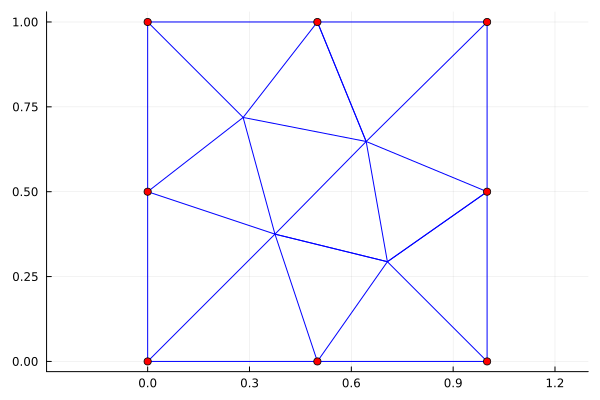

In [8]:
plot_mesh(MSH[1])

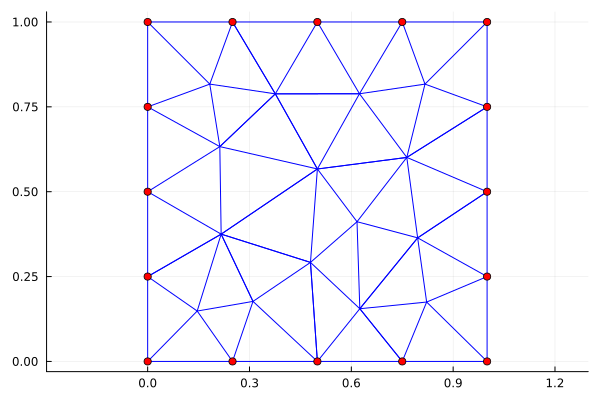

In [9]:
plot_mesh(MSH[2])

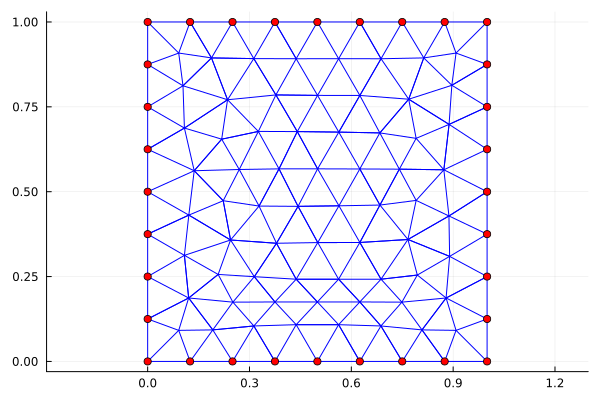

In [10]:
plot_mesh(MSH[3])

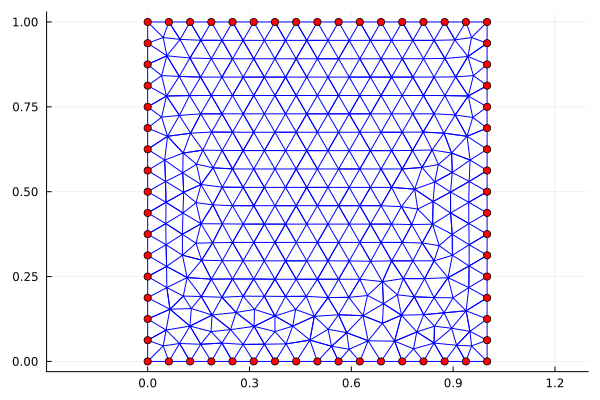

In [11]:
plot_mesh(MSH[4])

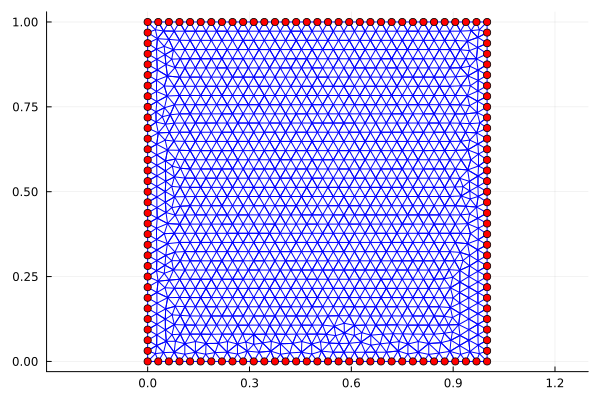

In [12]:
plot_mesh(MSH[5])

In [13]:
plot_mesh(MSH[6])

# Funciones de cuadratura en una malla de triángulos

La integral de una función escalar $v:\mathbb{R}^2 \rightarrow  \mathbb{R}$ sobre una región mallada $\Omega\subset \mathbb{R}^2 $, se puede calcular mediante la suma de integrales sobre cada elemento $K$ de una malla $T_h$:

$$\int_{\Omega} v(x) dx = \sum_{K\in T_h} \int_{K} v(x) dx$$

Para calcular la integral sobre un elemento $K$, se utiliza un cambio de variable para transformar la integral sobre el triángulo $\hat{K}$, que es un triángulo de referencia, al triángulo $K$. Este cambio de variable implica una transformación afín $T_K$ y una multiplicación por el determinante del Jacobiano de la transformación:
$$\int_{\Omega} v(x) dx = \sum_{K\in T_h} \int_{K} v(x) dx = \sum_{K\in T_h} \int_{\hat{K}}v\circ T_K(\hat{x}) \left\vert det\left(J_K\right) \right\vert d\hat{x}$$
donde $$x=T_K\left(\hat{x}\right) $$ y es tal que 

$$ K=T_K\left(\hat{K}\right) $$

Ahora para aproximar la integral sobre el triángulo de referencia $\hat{K}$, se utiliza una fórmula de cuadratura que involucra un conjunto de puntos de cuadratura y pesos, que dependen del orden de la precisión deseada:
$$\int_{\hat{K}}v\circ T_K(\hat{x})  d\hat{x} \approx  \sum_{l=1}^{l_q}\omega_l\ v\circ T_K(\hat{\xi}_l)   $$

$$\therefore
\int_{\Omega} v(x) dx \approx \sum_{K\in T_h} \left(\sum_{l=1}^{l_q}\omega_l\ v\circ T_K(\hat{\xi}_l) \right)    \left\vert det\left(J_K\right) \right\vert 
$$

En la siguiente tabla se muestran diferentes conjuntos de puntos de cuadratura y pesos para distintos grados de precisión. 

Los puntos de cuadratura se expresan en coordenadas baricéntricas, que son convenientes para trabajar con triángulos. La variable $S$ es la superficie del triángulo de referencia $\hat{K}$.

$$
\begin{array}{ccc|cc|c}
\hline n & k_{\mathrm{q}} & l_{\mathrm{q}} & \text { Barycentric coord. } & \text { Multiplicity } & \text { Weights } \omega_l \\
\hline 1 & 1 & 1 & \left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\right) & 1 & S \\
\hline 2 & 2 & 3 & \left(\frac{1}{6}, \frac{1}{6}, \frac{2}{3}\right) & 3 & \frac{1}{3} S \\
\hline 3 & 2 & 3 & \left(\frac{1}{2}, \frac{1}{2}, 0\right) & 3 & \frac{1}{3} S \\
\hline 4 & 3 & 4 & \left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\right) & 1 & -\frac{9}{16} S \\
& & & \left(\frac{1}{5}, \frac{1}{5}, \frac{3}{5}\right) & 3 & \frac{25}{48} S \\
\hline 5 & 3 & 7 & \left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\right) & 1 & \frac{9}{20} S \\
& & & \left(\frac{1}{2}, \frac{1}{2}, 0\right) & 3 & \frac{2}{15} S \\
& & & (1,0,0) & 3 & \frac{1}{20} S \\
\hline
\end{array}
$$

Ern, A., & Guermond, J. L. (2019). Theory and Practice of Finite Elements. Springer. Chapter 8. Quadratures, Assembling, and Storage. Table 8.2. Nodes and weights for quadratures on a triangle of area S, p 360.

Observaciones:
1. Sea $\hat{K} = \triangle OE_1E_2$ con nodos en $(0,0)$, $(1,0)$, $(0,1)$ y $K=\triangle Z_0Z_1Z_2 \in T_h$ un elemento de la malla. Entonces la transformación $T_K: \hat{K} \rightarrow K$ que lleva los vértices de $\hat{K}$ en los vértices de $K$ está dada por: 
$$x=T_K(\hat{x}) = J_K \hat{x} + z_0 \quad \hat{x}\in \hat{K} $$
Con 
$$J_K : = \left[ z_1-z_0 \  \  \vert \ \ z_2-z_0 \right]$$ 
y $z_i$ el vector columna con las coordenadas del punto $Z_i$
 y $z_i$ el vector columna con las coordenadas del punto $Z_i$

2. Si $\hat{\xi}_l$, un punto de la cuadratura, tiene coordenadas baricéntricas $(\lambda_0: \lambda_1 :\lambda_2)$, entonces 

Sus coordenadas en el simplejo de referencia $\hat{K}$ son: 

$$ \hat{\xi}_l = \lambda_0 \begin{pmatrix} 0\\\ 0\end{pmatrix} +\lambda_1 \begin{pmatrix}1\\\ 0\end{pmatrix} + \lambda_2 \begin{pmatrix} 0\\\ 1\end{pmatrix} = \begin{pmatrix}\lambda_1\\\ \lambda_2\end{pmatrix} $$ 

y sus coordenadas en el simplejo $K$ son: 

$$ T_K(\hat{\xi}_l) = J_K \hat{\xi}_l + z_0   $$


* Function: `quadratures_triangle(n::Int)`

In [14]:
"""
## `quadratures_triangle(n::Int)`

La función `quadratures_triangle` devuelve un diccionario que contiene los nodos
y pesos para una cuadratura en un triángulo de área uno.

## Argumentos:
- `n` : Número de la cuadratura a utilizar. Debe ser un entero en el rango `1` a `5`.

## Salida:
- Un diccionario que contiene los siguientes elementos:
    - `k`: Orden de la función polinómica exacta que se integra.
    - `l`: Número de puntos en la cuadratura.
    - `bary_coord`: Coordenadas baricéntricas de los puntos de cuadratura.
    - `multi`: Multiplicidad de los puntos de cuadratura.
    - `ω`: Pesos de los puntos de cuadratura.
"""
function quadratures_triangle(n::Int)
    # Definir las variables
    
    # grado máximo de los polinomios que se pueden integrar exactamente
    K = [1 2 2 3 3][n]  

    # número de puntos de cuadratura en la regla n
    L = [1 3 3 4 7][n]  

    # Coordenadas baricéntricas de los puntos de cuadratura. 
    Barycentric_Coord = Dict( "1" => [1//3 1//3 1//3],
                              "2" =>  [1//6 1//6 2//3],
                              "3" =>  [1//2 1//2 0//1],
                              "4" => [1//3 1//3 1//3; 1//5 1//5 3//5],
                              "5" => [1//3 1//3 1//3; 1//2 1//2 0//1; 1//1 0//1 0//1])    
    
    # Multiplicidades de los puntos de cuadratura
    Multiplicity = Dict( "1" => [1],
                         "2" => [3],
                         "3" => [3],
                         "4" => [1 3],
                         "5" => [1 3 3])
    
    # Pesos de los puntos de cuadratura
    Weights = Dict( "1" => [1],
                    "2" => [1//3],
                    "3" => [1//3],
                    "4" => [-9//16 25//48],
                    "5" => [9//20 2//15 1//20])
    
    # Crear y retornar el diccionario
        # coordenadas baricéntricas de los puntos de cuadratura
        bary_coord = Barycentric_Coord[string(n)]

        # multiplicidades de los puntos de cuadratura
        multi = Multiplicity[string(n)] 
        
        # pesos de los puntos de cuadratura
        ω = Weights[string(n)]  

    return Dict("k" => K, 
                "l" => L, 
                "bary_coord" => bary_coord, 
                "multi" => multi, 
                "ω" => ω)
end

quadratures_triangle

* Function: `gauss_points(bary_coord::Array, multi::Array, weights::Array)`

In [15]:
"""
## `gauss_points(bary_coord::Array, multi::Array, weights::Array)`

La función `gauss_points(bary_coord, multi, weights)` calcula los puntos 
y pesos de Gauss para la cuadratura en un triángulo.

## Argumentos:
- `coord`: matriz que contiene las triadas baricéntricas de la cuadratura. 
- `multi`: vector que especifica la multiplicidad de cada triada baricéntrica.
- `weights`: vector que especifica los pesos de cada triada baricéntrica.

## Salida:
- `gauss_coord`: matriz que contiene las coordenadas baricéntricas de los nodos de Gauss.
- `gauss_weights`: vector que contiene los pesos correspondientes a los nodos de Gauss.
"""
function gauss_points(bary_coord::Array, multi::Array, weights::Array)
    # Obtener las dimensiones de la matriz bary_coord.
    n_points, n_dim = size(bary_coord)
    n_q = sum(multi)

    # Crear matrices vacías para almacenar los puntos y pesos de Gauss.
    gauss_coord = zeros(Rational{Int64}, n_dim, n_q)
    gauss_weights = zeros(Rational{Int64}, n_q)

    idx_start = 1
    for i in 1:n_points
        # Encontrar todas las permutaciones únicas de los nodos de la triada actual.
        perms = unique(permutations(bary_coord[i,:]))
            
        # Crear una matriz para almacenar los puntos de Gauss para esta triada.
        sub_coord = zeros(Rational{Int64}, n_dim, multi[i])
        
        # Generar puntos de Gauss para esta barra.
        for j in 1:multi[i]
            sub_coord[:,j] = perms[j]
        end
        
        idx_end = idx_start + multi[i] - 1
        
        # Agregar los puntos de Gauss para esta triada a la matriz gauss_coord.
        gauss_coord[:,idx_start:idx_end] = sub_coord
        # Agregar los pesos de Gauss para esta triada a la matriz gauss_weights.        
        gauss_weights[idx_start:idx_end] .= weights[i]
        
        idx_start = idx_end + 1
    end
    
    return gauss_coord, gauss_weights
end

gauss_points

## Integral de una función dada una malla y una regla de cuadratura:

* Function: `quad_tri_loc(f::Function, points::Matrix, w_points::Vector)`

In [16]:
"""
## `quad_tri_loc(f::Function, points::Matrix, w_points::Vector)`

La función `cuadratura_triang_loc` calcula la cuadratura de una función en un triángulo
definido por los nodos de entrada usando el método de Gauss-Legendre.

## Argumentos
- `f`: Función a integrar
- `points`: Matriz de coordenadas globales de nodos de cuadratura.
            Cada columna corresponde a un nodo de cuadratura en el triángulo de la malla.
- `w_points`: Vector que contiene los pesos correspondientes a los nodos de la cuadratura.

## Salida
- `int_loc`: Valor de la integral de `f` en el triángulo.

"""
function quad_tri_loc(f, points, w_points)
# Evaluación de la función en los puntos de cuadratura
    fval = [f(points[:,i]) for i in 1:size(points,2)]
    
    # Cálculo de la integral local
    int_loc = 0.5 * dot(w_points, fval)
    return int_loc  
end

quad_tri_loc

* Function: `integrate_f_mesh(f::Function, mesh::Dict, n::Int)`

In [17]:
"""
## `integrate_f_mesh(f::Function, mesh::Dict, n::Int)`

Aproxima la integral de la función `f` en una malla triangular usando cuadratura Gaussiana.

## Argumentos
- `f`: función a integrar
- `mesh`: diccionario que contiene la información de la malla con las siguientes llaves:
  - `"nb_elems"`: número de elementos en la malla
  - `"nodes"`: matriz de coordenadas de los nodos
  - `"elems_nodes_conn"`: matriz de conectividad de los nodos de los elementos
- `n` : Número de la cuadratura a utilizar. Debe ser un entero en el rango `1` a `5`.

## Salida
- `int_glob`: aproximación al valor de la integral de `f`

"""
function integrate_f_mesh(f::Function, mesh::Dict, n::Int)
    # extraer nodos y conectividad de elementos de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
    
    # Generación de los puntos de la cuadratura
    quad = quadratures_triangle(n)
        ωl = quad["ω"]
        bary_coord = quad["bary_coord"]
        multi = quad["multi"]
    g_points, w_points  = gauss_points(bary_coord, multi, ωl)
    
    # Obtener las coordenadas locales de los puntos de la cuadratura
    g_points = g_points[2:3,:]

    # Cálculo de la integral global
    int_glob = 0.0
    for k in 1:nb_elems
        # Extracción de nodos y conectividad de elementos
        elem_nodes = elems_nodes_conn[k, 1:3] # coordenadas de los nodos del k-ésimo elemento
        q = collect(nodes[elem_nodes, :]')
        Jk = q[:,2:end] .- q[:,1]
        points = Jk * g_points .+ q[:,1]
    
        # Cálculo de la integral local
        int_loc = quad_tri_loc(f, points, w_points)*abs(det(Jk))
        int_glob += int_loc
    end
    return int_glob
end

integrate_f_mesh

### Ejemplo

Si $f(x,y) = x^4 sen(x) cos(y) $, entonces:

$$\int_0^1 \int_0^1 x^4 \sin(x) \cos(y) dx dy = -20 \sin^2(1) + 24 \sin(1) - \frac{13}{2}\sin(2) \approx 0.12340199555116005 $$



In [18]:
# Definimos la función
f(x) = x[1]^4*sin(x[1])*cos(x[2]) 

# Definimos la malla a utilizar
meshf = MSH[1]

# Definimos la cuadratura a utilizar
n_quad = 2;

# Aproximación de la integral
cuadf = integrate_f_mesh(f, meshf, n_quad)

0.12332682571969049

In [19]:
# Valor exacto de la integral
intf = -20*sin(1)^2+24*sin(1)-13*0.5*sin(2)

0.12340199555116005

In [20]:
# Error absoluto de la aproximación
abs(cuadf-intf)

7.51698314695598e-5

# Problema 1

Obtener el interpolador $v_I(x)$ de la funcion 
$$v(x,y)= \cos(4\pi x)\cdot cos^2(4\pi y)$$
para el dominio $\Omega ≔ (0, 1) \times (0, 1)$ utilizando

* Los elementos finitos de **Lagrange de primer orden**
* Los elementos finitos de **Crouzeix–Raviart de primer orden**
* Los elementos finitos de **Lagrange de segundo orden**

Obtener entonces la tasa de convergencia para el error $e:= v_I - v$ en la norma $L^2(\Omega)$ y la seminorma $H^1(\Omega)$ para la familia de mallas proporcionada.

## Definición de la función y su gradiente

In [21]:
# Definición de la función a interpolar
v = (x) -> cos(4*π*x[1])*(cos(4*π*x[2]))^2

# Definición del gradiente
∇v =  (x) -> [-4*π*sin(4*π*x[1])*(cos(4*π*x[2]))^2
              -8*π*cos(4*π*x[1])*cos(4*π*x[2])*sin(4*π*x[2])]

#5 (generic function with 1 method)

# Interpolador
## El Interpolador local

Para $K \in \mathcal{T}_h$, la tripleta $\left\{K, P_K, \Sigma_K\right\}$ definida por

$$
\begin{cases}
K=T_K(\hat{K}) \\
P_K=\left\lbrace \psi_K^{-1}(\hat{p}) ; \ \widehat{p} \in \hat{P}\right\rbrace ; \\
\Sigma_K=\left\lbrace \left\lbrace \sigma_{K, i}\right\rbrace_{1 \leq i \leq n_{s h}} ;\  \sigma_{K, i}(p)=\hat{\sigma}_i\left(\psi_K(p)\right), \ \forall p \in P_K\right\rbrace
\end{cases}
$$

es un elemento finito. 

Las funciones de forma locales son $$\theta_{K,i} = \psi_K ^{-1} \left( \hat{\theta_i} \right), 1 \leq i \leq n_{s h}  $$ y el operador de interpolación local $$\mathcal{I}_K: V(K) \longmapsto P_K$$ está dado por

$$
\mathcal{I}_K v =\sum_{i=1}^{n_{\mathrm{sh}}} \sigma_{K, i}(v) \theta_{K, i}
$$

- Para el elemento finito de Lagrange:
    * $K$ es un simplex en $\mathbb{R}^d$
    * $P_K=\mathbb{P}_k$, $n_{s h}=dim\left( \mathbb{P}_k\right), k\geq 1 $
    * $\sigma_{K, i}(p)=p(x_i)$, para $\left\lbrace x_i \right\rbrace_{i=1}^{n_{sh}}$ los nodos.
        
        Usando las coordenadas baricéntricas: $(\lambda_0, \lambda_1 ,\ldots , \lambda_d)$
        - Si $k=1$ las funciones de forma son: $$\theta_i = \lambda_i, \quad 0\leq i \leq d$$
        - Si $k=2$ las funciones de forma son: $$\theta = \begin{cases}  \lambda_i \left(2\lambda_i-1\right) & \quad 0\leq i \leq d \\   4\lambda_i\lambda_j & \quad 0\leq i < j \leq   d \\  \end{cases}$$
- Para el elemento finito de Crouzeix-Raviart:
    * $K$ es un simplex en $\mathbb{R}^d$
    * $P_K=\mathbb{P}_1$
    * $\sigma_{K, i}(v),\quad  0\leq i \leq d$ dado por: $$\sigma_{K, i}(v)=\frac{1}{\vert F_i\vert }\int_{F_i}v $$
    
    Usando las coordenadas baricéntricas: $(\lambda_0, \lambda_1 ,\ldots , \lambda_d)$
    $$\theta_i = d\left(\frac{1}{d}- \lambda_i \right), \quad 0\leq i \leq d$$


Como el siguiente diagrama conmuta:
$$
\begin{array}{cc}
V(K) \stackrel{\psi_K}{\longrightarrow} V(\hat{K}) \quad \\
\downarrow{\mathcal{I}_K} \quad  \quad \quad \downarrow \mathcal{I}_{\hat{K}} \\
P_K\quad \stackrel{\psi_K}{\longrightarrow}\quad \hat{P} \quad
\end{array}
$$

con 
$$\mathcal{I}_{\hat{K}}: V(\hat{K}) \longmapsto \hat{P}$$ 
$$
\mathcal{I}_{\hat{K}} \hat{v} =\sum_{i=1}^{n_{\mathrm{sh}}} \hat{\sigma}_{i}(\hat{v}) \hat{\theta}_i
$$ el operador de interpolación de referencia.


Entonces podemos expresar el interpolador local en términos del elemento finito de referencia:

$$ \mathcal{I}_K v(x) = \sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)\ \theta_{K,i}(x)=  \sum_{i=1}^{n_{sh}}  \sigma_{K,i}(v)\ \psi_K^{-1}\left(\hat{\theta}_i\right)\left(x\right) =\sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)\ \left(\hat{\theta}_i\circ T_K^{-1}\right)(x)$$


Para nuestro problema $d=2$, tenemos

- Elementos finitos de Lagrange de primer orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \end{pmatrix}= \begin{pmatrix} \lambda_0 \\ \lambda_1 \\ \lambda_2 \end{pmatrix} $$
- Elementos finitos de Crouzeix–Raviart de primer orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \end{pmatrix}= \begin{pmatrix} 1-2\lambda_0 \\ 1-2\lambda_1 \\ 1-2\lambda_2 \end{pmatrix} $$
- Elementos finitos de Lagrange de segundo orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \\ \theta_5 \end{pmatrix}= \begin{pmatrix} \lambda_0(2\lambda_0-1) \\ \lambda_1(2\lambda_1-1)\\ \lambda_2(2\lambda_2-1) \\ 4\lambda_0\lambda_1 \\ 4\lambda_1\lambda_2 \\ 4\lambda_0\lambda_2 \end{pmatrix} $$

* Function: `get_θ_functions(ξ::Vector, ef::Int)`

In [22]:
"""
## `get_θ_functions(ξ::Vector, ef::Int)`

Calcula las funciones de forma locales en el punto `ξ` para el elemento finito `ef`, 

## Argumentos
- `ξ` : Coordenadas locales de un punto en el simplejo de referencia. 
- `ef` : Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- `θ` : Funciones de forma locales en el punto `ξ`

"""
function get_θ_functions(ξ::Vector, ef::Int) 
    # Inicializar variable para almacenar las funciones de forma
    λ = [1 - ξ[1] - ξ[2], ξ[1], ξ[2]]
    
    # Calcular las funciones de forma según el tipo de elemento finito
    if ef == 1 # Elementos de Lagrange de primer orden
        θ = λ
    elseif ef == 2 # Elementos de Crouzeix-Raviart de primer orden
        θ = -2*λ .+ 1            
    elseif ef == 3 # Elementos de Lagrange de segundo orden
        θ = zeros(6)
        θ[1] = λ[1]*(2λ[1]-1)
        θ[2] = λ[2]*(2λ[2]-1)
        θ[3] = λ[3]*(2λ[3]-1)
        θ[4] = 4λ[1]*λ[2]
        θ[5] = 4λ[2]*λ[3]
        θ[6] = 4λ[1]*λ[3]
    else
        throw(ArgumentError("Tipo de elemento finito no válido"))
    end
    
    return θ
end

get_θ_functions

## El Interpolador global

Usando la familia de elementos finitos $\left\lbrace K, P_K, \Sigma_K \right\rbrace_{K \in \mathcal{T}_h}$, se puede construir un operador de interpolación global $\mathcal{I}_h$ de la siguiente manera: primero, se elige su dominio como
$$
D\left(\mathcal{I}_h\right)=\left\{v \in\left[L^1\left(\Omega_h\right)\right]^m ; \forall K \in \mathcal{T}_h, v_{\mid K} \in V(K)\right\}
$$

donde $\Omega_h$ es la interpolación geométrica de $\Omega$. Para una función $v \in D\left(\mathcal{I}h\right)$, las cantidades $\sigma_{K, i}\left(v_{\mid K}\right)$ tienen sentido en todos los elementos de la malla y para todo $1 \leq i \leq n_{\text {sh }}$. Luego, el interpolante global $\mathcal{I}_h v$ se puede especificar elemento por elemento utilizando los operadores de interpolación local, es decir,

$$
\forall K \in \mathcal{T}_h, \quad\left(\mathcal{I}_h v\right)_{\mid K}=\mathcal{I}_K\left(v_{\mid K}\right)=\sum_{i=1}^{n_{\text {sh }}} \sigma_{K, i}\left(v_{\mid K}\right) \theta_{K, i}
$$

El operador de interpolación global se define de la siguiente manera:
$$
\mathcal{I}_h: D\left(\mathcal{I}_h\right)  \longmapsto W_h,
$$

$$
\mathcal{I}_h (v) := \sum_{K \in \mathcal{T}_h} \sum_{i=1}^{n_{\mathrm{ah}}} \sigma_{K, i}\left(v_{\mid K}\right) \theta_{K, i} 
$$
donde $W_h$, el codominio de $\mathcal{I}_h$, es
$$
W_h=\left\{v_h \in\left[L^1\left(\Omega_h\right)\right]^m ; \forall K \in \mathcal{T}_h, v_{\mid K} \in P_K\right\}
$$

El espacio $W_h$ se llama espacio de aproximación.

## Error en $L^2$ del Interpolador global

Para el error del interpolador global en $L^2$ tenemos:

$$\Vert \mathcal{I}_h v-v\Vert_{L^2}^2 = \sum_{K \in \mathcal{T}_h} \int_{K} \left( \mathcal{I}_h v\vert_{K}-v\vert_{K}\right)^2(x) dK = \sum_{K \in \mathcal{T}_h} \int_{\hat{K}} \left|\operatorname{det}\left(J_K\right)\right| \left( \mathcal{I}_K v-v\vert_{K}\right)^2\circ T_K(\hat{x}) d\hat{K} $$ 

$$\therefore \Vert \mathcal{I}_h v-v\Vert_{L^2}^2 \approx \sum_{K \in \mathcal{T}_h}\left|\operatorname{det}\left(J_K\right)\right| \sum_{l=1}^{l_q} \omega_l\left[\left( \mathcal{I}_K v-v\right)^2 \circ T_K\right]\left(\hat{\xi}_l\right)$$

* Function: `error_local_L2(v::Function, σ_T::Array, X::Array, ξ::Array, ω::Array, ef::Int)`

In [23]:
"""
## `error_local_L2(v::Function, σ_T::Vector, X::Array, ξ::Array, ω::Array, ef::Int)`

Calcula el error local en L² del interpolador de la función v sobre el triángulo T,
en el elemento finito `ef`:

## Argumentos
- `v` : Solución exacta
- `σ_T` : Vector con grados de libertad.
- `X` : Matriz con Coordenadas globales de los gauss points.
- `ξ` : Matriz con Coordenadas locales de los gauss points. 
- `ω` : Vector con pesos de los gauss points. 
- `ef`: Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- Error local en L² del interpolador de la función v
"""
function error_local_L2(v::Function, σ_T::Array, X::Array, ξ::Array, ω::Array, ef::Int)
    # Número de puntos de la cuadratura
    l_q = length(ω)
    
    # Inicialización del vector de residuos al cuadrado
    squared_residuals = zeros(l_q)
    
    # Bucle sobre los puntos de cuadratura
    for i in 1:l_q
        # Punto de cuadratura y funciones de forma del elemento finito
        x = X[:,i]
        θ = get_θ_functions(ξ[:,i], ef)
        
        # Interpolación y cálculo del residuo al cuadrado
        Iv_T = dot(σ_T, θ)
        res = v(x) - Iv_T
        squared_residuals[i] = res^2
    end
    
    # Cálculo del error local en L2
    err_loc = 0.5 * dot(1.0*ω, squared_residuals)
    return err_loc    
end

error_local_L2

## Error en $H^1$ del Interpolador local

Para el error del interpolador local en $H^1$ tenemos:

$$\Vert  \nabla \mathcal{I}_h v-\nabla v\Vert_{L^2}^2 = \sum_{K \in \mathcal{T}_h} \int_{K} \left( \nabla \mathcal{I}_h v\vert_{K}-\nabla v\vert_{K}\right)^2(x) dK = \sum_{K \in \mathcal{T}_h} \int_{\hat{K}} \left|\operatorname{det}\left(J_K\right)\right| \left( \nabla  \mathcal{I}_K v-\nabla v\vert_{K}\right)^2\circ T_K(\hat{x}) d\hat{K} $$ 

$$\therefore \Vert \mathcal{I}_h v-v\Vert_{L^2}^2 \approx \sum_{K \in \mathcal{T}_h}\left|\operatorname{det}\left(J_K\right)\right| \sum_{l=1}^{l_q} \omega_l\left[\left( \nabla \mathcal{I}_K v-\nabla v\right)^2 \circ T_K\right]\left(\hat{\xi}_l\right)$$



Ya que $$ \mathcal{I}_K v(x) = \sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)\ \theta_{K,i}(x)=  \sum_{i=1}^{n_{sh}}  \sigma_{K,i}(v)\ \psi_K^{-1}\left(\hat{\theta}_i\right)\left(x\right) =\sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)\ \left(\hat{\theta}_i\circ T_K^{-1}\right)(x)$$

Entonces podemos obtener el gradiente como sigue:
$$\nabla_x \mathcal{I}_K v(x)  =\sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)\nabla_x  \left(\hat{\theta}_i\circ T_k^{-1}\right)(x) =\sum_{i=1}^{n_{sh}} \sigma_{K,i}(v) \nabla_\hat{x} \hat{\theta}_i  (\hat{x}) \frac{\partial T_k^{-1}(x)}{\partial x}  =\sum_{i=1}^{n_{sh}} \sigma_{K,i}(v)  \nabla_\hat{x} \hat{\theta}_i (\hat{x}) \frac{\partial \hat{x} }{\partial x}$$
$$ \therefore \nabla_x \mathcal{I}_K v(x) =  \sum_{i=1}^{n_{sh}} \sigma_{K,i}(v) \nabla_\hat{x} \hat{\theta}_i  (\hat{x})J_K^{-1}  $$

Que en notación vectorial podemos escribir como
$$\nabla_x \mathcal{I}_K v(x) = \sigma_K^t(v) \cdot D_\hat{x} \theta (\hat{x})\cdot J_K^{-1}$$

Para nuestro problema $d=2$, tenemos

- Elementos finitos de Lagrange de primer orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \end{pmatrix}= \begin{pmatrix} \lambda_0 \\ \lambda_1 \\ \lambda_2 \end{pmatrix} = \begin{pmatrix} 1-\hat{x}_1-\hat{x}_2 \\ \hat{x}_1\\ \hat{x}_2 \end{pmatrix} \implies D_\hat{x}\theta = \begin{pmatrix}-1 & -1 \\ \ 1&\ 0 \\ \ 0&\ 1\end{pmatrix} $$
- Elementos finitos de Crouzeix–Raviart de primer orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \end{pmatrix}= \begin{pmatrix} 1-2\lambda_0 \\ 1-2\lambda_1 \\ 1-2\lambda_2 \end{pmatrix}\implies D_\hat{x}\theta = \begin{pmatrix}\ \ 2 & \ 2 \\ -2 &\ 0 \\ \ \ 0&-2 \end{pmatrix}   $$
- Elementos finitos de Lagrange de segundo orden
$$\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \\ \theta_5 \end{pmatrix}= \begin{pmatrix} \lambda_0(2\lambda_0-1) \\ \lambda_1(2\lambda_1-1)\\ \lambda_2(2\lambda_2-1) \\ 4\lambda_0\lambda_1 \\ 4\lambda_1\lambda_2 \\ 4\lambda_0\lambda_2 \end{pmatrix}\implies D_\hat{x}\theta =D_{\lambda}  \theta\cdot D_{\hat{x}} \lambda = \begin{pmatrix}
1-4\lambda_0&1-4\lambda_0\\
4\lambda_1-1&0\\
0 &4\lambda_2-1\\
4(\lambda_0-\lambda_1)&-4\lambda_1\\
4\lambda_2 &4\lambda_1\\
-4\lambda_2 &4(\lambda_0-\lambda_2)   \end{pmatrix}  $$

* Function: `get_Dθ_functions(ξ::Vector, ef::Int)`

In [24]:
"""
## `get_Dθ_functions(ξ::Vector, ef::Int)`

Calcula la derivada de funciones de forma locales en el punto `ξ`
para el elemento finito `ef`.

## Argumentos
- `ξ` : Coordenadas locales de un punto en el simplejo de referencia. 
- `ef` : Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- `Dθ` : Derivada de funciones de forma locales en el punto `ξ`
"""
function get_Dθ_functions(ξ::Vector, ef::Int)
    # Calcular las funciones de forma según el tipo de elemento finito
        if ef == 1
            Dθ = [-1 -1; 1 0; 0 1]
        elseif ef == 2
            Dθ = -2*[-1 -1; 1 0; 0 1]
        elseif ef == 3
            λ = [1-ξ[1]-ξ[2], ξ[1], ξ[2]]
            Dθ = [1-4λ[1] 4λ[2]-1 0 4λ[1]-4λ[2] 4λ[3] -4λ[3];
                  1-4λ[1] 0 4λ[3]-1 -4λ[2] 4λ[2] 4λ[1]-4λ[3]]'    
    else
            throw(ArgumentError("Tipo de elemento finito no válido"))
        end
    return Dθ
end

get_Dθ_functions

* Function: `error_local_H1(∇v::Function, σ_T::Vector, invJₖ::Matrix, X::Array, ξ::Array, ω::Array, ef::Int)`

In [25]:
"""
## `error_local_H1(∇v::Function, σ_T::Vector, invJₖ::Matrix, X::Array, ξ::Array, ω::Array, ef::Int)`

Calcula el error local en H¹ del interpolador de la función v sobre el triángulo T,
en el elemento finito `ef`:

## Argumentos
- `∇v` : Gradiente de la Solución exacta
- `σ_T` : Vector con grados de libertad.
- `invJₖ` : Matriz inversa de Jₖ
- `X` : Matriz con Coordenadas globales de los gauss points.
- `ξ` : Matriz con Coordenadas locales de los gauss points. 
- `ω` : Vector con pesos de los gauss points. 
- `ef`: Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- Error local en H¹ del interpolador de la función v
"""
function error_local_H1(∇v::Function, σ_T::Vector, invJₖ::Matrix, X::Array, ξ::Array, ω::Array, ef::Int)
    # Número de puntos de la cuadratura
    l_q = length(ω)
    
    # Inicialización del vector de residuos al cuadrado
    squared_residuals = zeros(l_q)
    
    # Bucle sobre los puntos de cuadratura
    for i in 1:l_q
        x = X[:, i]
        
        # Derivada del Interpolador  
        Dθ = get_Dθ_functions(ξ[:,i], ef)
        ∇Iv_T = σ_T'*Dθ*invJₖ
        
        #  Cálculo del residuo al cuadrado 
        res = ∇v(x) - vec(∇Iv_T)
        squared_residuals[i] = dot(res, res)
    end
    
    # Cálculo del error local en H1
    err_loc = 0.5 * dot(1.0*ω, squared_residuals)
    return err_loc    
end

error_local_H1

# Grados de Libertad

* Function: `cuadratura_gauss(f::Function, a::Number, b::Number)`

In [26]:
"""
### `cuadratura_gauss(f::Function, a::Number, b::Number)`

Aproxima el valor de la integral de la función `f` en el intervalo `[a,b]` utilizando
la fórmula de cuadratura de Gauss-Legendre con tres nodos.

### Argumentos

- `f`: Función a integrar.
- `a`: Límite inferior del intervalo de integración.
- `b`: Límite superior del intervalo de integración.

### Salida

- `val`: Aproximación del valor de la integral de `f` en el intervalo `[a,b]`.

"""
function cuadratura_gauss(f::Function, a, b)
        # Nodos de la cuadratura
        x₁ = -0.5*(b-a)*sqrt(3/5) + 0.5*(a+b)   # Nodo x₁
        x₂ = 0.5*(a + b)                        # Nodo x₂
        x₃ = 0.5*(b-a)*sqrt(3/5) + 0.5*(a+b)    # Nodo x₃
    
        # Cálculo de integral utilizando la fórmula de cuadratura de Gauss-Legendre
        val = 5*f(x₁) + 8*f(x₂) + 5*f(x₃)       # Suma ponderada de f en los nodos
        val = 0.5*(b-a)*val/9                   # Multiplicación por el factor de escala
    
    return val  # Retorna el valor aproximado de la integral de f en [a,b]
end

cuadratura_gauss

* Function: `get_σ_interpolator(v::Function, K::Matrix, ef::Int)`

In [27]:
"""
## `get_σ_interpolator(v::Function, K::Matrix, ef::Int)`

Devuelve el vector de grados de libertar en el simplejo `K` para el elemento finito `ef`.

## Argumentos
- `v` : Función a Interpolar
- `K` : Coordenadas los vértices del simplejo K. 
- `ef` : Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- `σ_T` : Vector de grados de libertar en el simplejo `K`.
"""
function get_σ_interpolator(v::Function, K::Matrix, ef::Int)
        z₀ = K[:,1]
        z₁ = K[:,2]
        z₂ = K[:,3]
        
        if ef == 1 
            σ_T = zeros(3)
            σ_T = [v(z₀), v(z₁), v(z₂)]
        elseif ef == 2   
            σ_T = zeros(3)
            f₁(t) = v((1-t)*z₀+t*z₁)
            f₂(t) = v((1-t)*z₁+t*z₂)
            f₃(t) = v((1-t)*z₂+t*z₀)
            σ_T[1] = cuadratura_gauss(f₂, 0, 1)
            σ_T[2] = cuadratura_gauss(f₃, 0, 1)
            σ_T[3] = cuadratura_gauss(f₁, 0, 1)
        elseif ef == 3 
            σ_T = zeros(6)
            σ_T[1] = v(z₀)
            σ_T[2] = v(z₁)
            σ_T[3] = v(z₂)
            σ_T[4] = v(0.5*z₀+0.5*z₁)            
            σ_T[5] = v(0.5*z₂+0.5*z₁)                   
            σ_T[6] = v(0.5*z₀+0.5*z₂)
        else
            throw(ArgumentError("Tipo de elemento finito no válido"))
        end
    return σ_T
end

get_σ_interpolator

# Tasa de convergencia del error en $L^2$ y $H^1$

* Function: `error_global(v::Function, ∇v::Function, mesh::Dict, n::Int, ef::Int)`

In [28]:
"""
## `error_global(v::Function, ∇v::Function, mesh::Dict, n::Int, ef::Int)`

Calcula el error global de interpolación en la norma L² y la seminorma H¹
en una malla de elementos finitos para una función de interpolación `v` 
y su gradiente `∇v`. Utiliza un esquema de cuadratura de Gauss para evaluar
la función a través de su interpolación y compara los valores obtenidos con
la solución exacta. 

## Argumentos
- `v` : Solución Exacta.
- `∇v` : Gradiente de la Solución Exacta.
- `mesh` : Diccionario que contiene la información de la malla de elementos finitos. 
- `n` : Índice de la Cuadratura para la integración
    - `n` = 1 : Gaussiana-01 de 1 punto
    - `n` = 2 : Gaussiana-02 de 3 puntos
    - `n` = 3 : Gaussiana-03 de 3 puntos
    - `n` = 4 : Gaussiana-04 de 4 puntos
    - `n` = 5 : Gaussiana-05 de 7 puntos
- `ef` : Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden

## Salida
- `err_L2`: error global de interpolación en la norma L².
- `err_H1`: error global de interpolación en la seminorma H¹.

"""
function error_global(v::Function, ∇v::Function, mesh::Dict, n::Int, ef::Int)
    # Extraer nodos y conectividad de elementos de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
    
    # Generación de los puntos de la cuadratura
    quad = quadratures_triangle(n)
        ω_l = quad["ω"]
        bary_coord = quad["bary_coord"]
        multi = quad["multi"]
        g_points, ω = gauss_points(bary_coord, multi, ω_l)
        # Obtener las coordenadas locales de los puntos de la cuadratura
        ξ = g_points[2:3,:]

    err_L2 = 0.0
    err_H1 = 0.0
    # Cálculo del error de interpolación global en L2 y H1
    for k in 1:nb_elems
        # Extracción de nodos y conectividad de elementos
        elem_nodes = elems_nodes_conn[k, 1:3] # coordenadas de los nodos del k-ésimo elemento
        K = collect(nodes[elem_nodes, :]')
        
        # Definiendo la transformación Tₖ
        Jk = K[:,2:end] .- K[:,1]
        X = Jk * ξ .+ K[:,1]
        invJₖ = inv(Jk)
        detJₖ = det(Jk)
        
        # Obteniendo los grados de libertad
        σ_T = get_σ_interpolator(v, K, ef)
        
        # Cálculo del error de interpolación local en L2 y H1
        err_loc_L2 = error_local_L2(v, σ_T, X, ξ, ω, ef)  
        err_loc_H1 = error_local_H1(∇v, σ_T, invJₖ, X, ξ, ω, ef)
        
        err_L2 += err_loc_L2*abs(detJₖ)
        err_H1 += err_loc_H1*abs(detJₖ)
    end
    err_L2 = sqrt(err_L2)
    err_H1 = sqrt(err_H1)
    
    return err_L2, err_H1
end

error_global

# Cálculo de la tasa de convergencia en L2 y H1

* Function: `refina(v::Function, ∇v::Function, MSH::Array, ef::Int, n::Int)`

In [29]:
"""
## `refina(v::Function, ∇v::Function, MSH::Array, ef::Int, n::Int)`

Función que calcula los errores de aproximación en la norma L² y la seminorma H¹,
realiza un análisis de convergencia de error para el interpolador utilizando
diferentes refinamientos en una malla y diferentes elementos finitos. 

## Argumentos
- `v` : Solución Exacta.
- `∇v` : Gradiente de la Solución Exacta.
- `MESH` : Arreglo de diccionarios que contiene la información de las mallas del refinamiento.
- `ef` : Índice del Elemento finito
    - `ef` = 1 : Elementos finitos de Lagrange de primer orden
    - `ef` = 2 : Elementos finitos de Crouzeix–Raviart de primer orden
    - `ef` = 3 : Elementos finitos de Lagrange de segundo orden
- `n` : Índice de la Cuadratura para la integración
    - `n` = 1 : Gaussiana-01 de 1 punto
    - `n` = 2 : Gaussiana-02 de 3 puntos
    - `n` = 3 : Gaussiana-03 de 3 puntos
    - `n` = 4 : Gaussiana-04 de 4 puntos
    - `n` = 5 : Gaussiana-05 de 7 puntos
## Salida
- La función retorna la tabla de resultados.
"""
function refina(v::Function, ∇v::Function, MSH::Array, ef::Int, n::Int)
    # Selección de Elemento finito
        if ef == 1
            println("Elemento finito: Lagrange Orden 1")
        elseif ef == 2
            println("Elemento finito: Crouzeix–Raviart Orden 1")
        elseif ef == 3
            println("Elemento finito: Lagrange Orden 2")
        else
            throw(ArgumentError("Tipo de elemento finito no válido"))
        end
    
    # Selección de Cuadratura
        if n == 1
            println("Cuadratura: Gaussiana-01 de 1 punto")
        elseif n == 2
            println("Cuadratura: Gaussiana-02 de 3 puntos")
        elseif n == 3
            println("Cuadratura: Gaussiana-03 de 3 puntos")
        elseif n == 4
            println("Cuadratura: Gaussiana-04 de 4 puntos")
        elseif n == 5
            println("Cuadratura: Gaussiana-05 de 7 puntos")
        else
            throw(ArgumentError("Elección de cuadratura no válida"))
        end    
    
    # Inicializar vector con error en L² para cada refinamiento
    L2_error_vec = zeros(6)
    # Inicializar vector con error en H¹ para cada refinamiento
    H1_error_vec = zeros(6)
    # Inicializar vector con parámetro global h
    h_global = zeros(6)
            
    # Ciclos de refinamiento
    for i in 1:6
        # Calculo del error en la norma L² y en la seminorma H¹
        L2_error_vec[i], H1_error_vec[i] = error_global(v, ∇v, MSH[i], n, ef)
        h_global[i] = get_h_global(MSH[i])
    end
    
    # Inicializar vector con tasa de convergencia en L²
    err_rate_L2 = zeros(6)
    err_rate_L2[1] = 1
            
    # Inicializar vector con tasa de convergencia en H¹
    err_rate_H1 = zeros(6)
    err_rate_H1[1] = 1

    for i = 2:6
        # Cálculo de la tasa de convergencia en L² y en H¹
        err_rate_L2[i] = log(L2_error_vec[i]/L2_error_vec[i-1])/log(1/2)
        err_rate_H1[i] = log(H1_error_vec[i]/H1_error_vec[i-1])/log(1/2)
    end
            
    # Creación de tabla con resultados 
    data = [ h_global L2_error_vec err_rate_L2 H1_error_vec err_rate_H1]    
    table= pretty_table(data; formatters = ft_printf("%1.7f") ,
        header = (["Parámetro h", "Error L²_norm", "Rate L²_norm", 
                    "Error H¹_norm", "Rate H¹_norm"]))
    
    return table
end

refina

# Presentación de resultados

In [30]:
@time refina(v, ∇v, MSH, 1, 5)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.6596904 │    1.0000000 │     8.2485125 │    1.0000000 │
│   0.3423854 │     0.4496413 │    0.5530146 │     6.9950336 │    0.2378030 │
│   0.1520212 │     0.1473130 │    1.6098901 │     5.0794873 │    0.4616481 │
│   0.0792050 │     0.0558648 │    1.3988724 │     3.0743890 │    0.7243832 │
│   0.0411692 │     0.0145517 │    1.9407507 │     1.5905570 │    0.9507677 │
│   0.0201700 │     0.0036800 │    1.9833937 │     0.7998152 │    0.9917935 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  5.494793 seconds (10.17 M allocations: 766.991 MiB, 3.52% gc time, 92.02% compilation time)


In [31]:
@time refina(v, ∇v, MSH, 2, 5)

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.4314069 │    1.0000000 │     6.7387760 │    1.0000000 │
│   0.3423854 │     0.2985520 │    0.5310671 │     5.8420809 │    0.2060042 │
│   0.1520212 │     0.0919788 │    1.6986096 │     4.3226416 │    0.4345691 │
│   0.0792050 │     0.0326415 │    1.4945924 │     2.5023374 │    0.7886369 │
│   0.0411692 │     0.0084430 │    1.9508759 │     1.2922393 │    0.9534030 │
│   0.0201700 │     0.0021287 │    1.9878123 │     0.6517931 │    0.9873874 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  0.847934 seconds (2.48 M allocations: 381.003 MiB, 13.42% gc time)


In [32]:
@time refina(v, ∇v, MSH, 3, 5)

Elemento finito: Lagrange Orden 2
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.2841278 │    1.0000000 │     8.0323610 │    1.0000000 │
│   0.3423854 │     0.0928317 │    1.6138510 │     6.9346450 │    0.2120021 │
│   0.1520212 │     0.0217665 │    2.0925059 │     3.1538145 │    1.1367242 │
│   0.0792050 │     0.0017820 │    3.6105501 │     0.8026173 │    1.9743137 │
│   0.0411692 │     0.0001447 │    3.6226096 │     0.2081855 │    1.9468424 │
│   0.0201700 │     0.0000118 │    3.6175815 │     0.0523020 │    1.9929310 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  1.028595 seconds (4.13 M allocations: 586.153 MiB, 15.57% gc time)


# Solución EDP

Aproximar numéricamente utilizando los elementos finitos de Lagrange de primer orden la solución débil del siguiente problema con valores en la frontera:
$$
\begin{aligned}
-\nabla \cdot(k(x) \nabla u) & =f(x) & & \text { en } \Omega:=(0,1) \times(0,1), \\
u & =0 & & \text { en } \partial \Omega,
\end{aligned}
$$


donde
$$
f(x)=8 \pi \sin \left(4 \pi x_2\right)\left(4 \pi x_1^2 \sin \left(4 \pi x_1\right)+4 \pi \sin \left(4 \pi x_1\right)-x_1 \cos \left(4 \pi x_1\right)\right), \quad k(x)=1+x_1^2$$

* Verificar que $u(x)=\sin \left(4 \pi x_1\right) \sin \left(4 \pi x_2\right)$ es la solución del problema. 

* Obtener entonces la tasa de convergencia para el error $e:=u_h-u$ en las normas $L^2(\Omega)$ y la seminorma $H^1(\Omega)$ para la familia de mallas proporcionada en la página del curso.

## La formulación débil del problema:

Multiplicando la ecuación diferencial por una función de prueba $v(x)$

$$
-\nabla \cdot(\kappa(x) \nabla u) v(x)=f(x) v(x)
$$

Integrando por partes en el dominio $\Omega$:
$$
\begin{array}{c}
\int_{\Omega} \nabla \cdot(\kappa(x) \nabla u) v(x) \mathrm{d} x=\int_{\Omega} f(x) v(x) \mathrm{d} x \\
-\int_{\partial \Omega} \kappa(x) \nabla u \cdot \mathbf{n} v(x) \mathrm{d} s+\int_{\Omega} \kappa(x) \nabla u \cdot \nabla v(x) \mathrm{d} x=\int_{\Omega} f(x) v(x) \mathrm{d} x
\end{array}
$$

Aplicando la condición de frontera homogénea $u=0$ en $\partial \Omega$:
$$
\int_{\Omega} \kappa(x) \nabla u \cdot \nabla v(x) \mathrm{d} x=\int_{\Omega} f(x) v(x) \mathrm{d} x
$$


## Aproximación numérica de la solución

Para aproximar numéricamente la solución débil del problema, primero dividimos el dominio $\Omega$ en una malla de elementos triangulares con nodos en los vértices. 

Aproximar la solución y la función de prueba como combinaciones lineales de las funciones de forma de Lagrange de primer orden:
$$
u(x) \approx u_h =\sum_{i=1}^{n_{\text {nods }}} u_i \phi_i(x) \quad \text { y } \quad v(x) \approx \sum_{j=1}^{n_{\text {nods }}} v_j \phi_j(x)
$$

donde $n_{\text{nods}}$ es el número total de nodos en la malla y $u_i$ y $v_j$ son los coeficientes desconocidos asociados a las funciones de forma $\phi_i(x)$ y $\phi_j(x)$, respectivamente.

Sustituimos las aproximaciones de la solución y la función de prueba en la ecuación integral y reordenamos los términos para obtener una forma matricial del problema:

$$\sum_{j=1}^{n_{\text {nods }}}\left[\int_{\Omega} \kappa(x) \nabla \phi_i(x) \cdot \nabla \phi_j(x) \mathrm{d} x\right] u_j=\int_{\Omega} f(x) \phi_i(x) \mathrm{d} x \quad \operatorname{para} i=1, \ldots, {n_{\text {nods }}}$$

donde $A_{i,j} := \int_{\Omega} \kappa(x) \nabla \phi_{i}(x) \cdot \nabla \phi_{j}(x) \mathrm{d} x$ es la matriz de rigidez y $b_i := \int_{\Omega} f(x) \phi_{i}(x) \mathrm{d} x$ es el vector de carga.

Por lo tanto, la solución numérica del problema se obtiene resolviendo el sistema lineal $A\mathbf{u} = \mathbf{b}$, donde $\mathbf{u}$ es el vector de coeficientes nodales de la aproximación de la solución $u(x)$ y $\mathbf{b}$ es el vector de carga.

En términos del simplejo de referencia tenemos:

* $$ a\left(\theta_{k, i}, \theta_{k, j}\right)=\int_{\Omega}\left( \kappa \nabla \theta_{K, i} \cdot \nabla  \theta_{k, j}\right)(x) dx =\sum_{K \in \mathcal{T}_h} \int_{K} \left( \kappa \nabla \theta_{K, i} \cdot \nabla  \theta_{k, j}\right)(x) dK = \sum_{K \in \mathcal{T}_h} \int_{\hat{K}} \left|\operatorname{det}\left(J_K\right)\right| \left( \kappa \nabla \theta_{K, i} \cdot \nabla  \theta_{k, j}\right)\circ T_K(\hat{x}) d\hat{K} $$ 

$$\therefore a\left(\theta_{k, i}, \theta_{k, j}\right) \approx \sum_{K \in \mathcal{T}_h}\left|\operatorname{det}\left(J_K\right)\right| \sum_{l=1}^{l_q} \omega_l\left[\left( \kappa \nabla \theta_{K, i} \cdot \nabla  \theta_{k, j}\right) \circ T_K\right]\left(\hat{\xi}_l\right)$$



* $$ \left(f, \theta_{k, i}\right)=\int_{\Omega}\left(f  \theta_{k, i}\right)(x) dx =\sum_{K \in \mathcal{T}_h} \int_{K} \left( f \theta_{k, i}\right)(x) dK = \sum_{K \in \mathcal{T}_h} \int_{\hat{K}} \left|\operatorname{det}\left(J_K\right)\right| \left( f \theta_{k, i}\right)\circ T_K(\hat{x}) d\hat{K} $$ 

$$\therefore \left(f, \theta_{k, i}\right) \approx \sum_{K \in \mathcal{T}_h}\left|\operatorname{det}\left(J_K\right)\right| \sum_{l=1}^{l_q} \omega_l\left[\left(f \theta_{k, i} \right) \circ T_K\right]\left(\hat{\xi}_l\right)$$

In [33]:
κ(x) = 1+x[1]^2
f(x) = 8*π*sin(4π*x[2])*( 4*π*x[1]^2*sin(4π*x[1]) + 4*π*sin(4π*x[1]) - x[1]*cos(4π*x[1]) )

f (generic function with 1 method)

## Solución de la EDP

In [34]:
function quad_tri_loc_2(f, X, Θ, ξ, ω)
# Evaluación de la función en los puntos de cuadratura
    fval = [f( X[:,i]) for i in 1:size(X,2)]
    Θval = [Θ(ξ[:,i]) for i in 1:size(ξ,2)]
    
    # Cálculo de la integral local
    int_loc = 0.5 * dot(ω, fval.*Θval)
    return int_loc  
end

quad_tri_loc_2 (generic function with 1 method)

In [35]:
function solve_edp(mesh, f, κ, n)
    nb_nodes = mesh["nb_nodes"]                  # número de nodos/vértices en la malla
    mode_on = zeros(Int64, nb_nodes,2)           # creación de matriz de conectividad
    nb_on = .!(mesh["onodes_bool"])              # indices booleanos de nodos en el interior
    mode_on[:,1] = nb_on                         # llenar primera columna de matriz mode_on
    nb_elems = mesh["nb_elems"]                  # número de elementos/simplejos en la malla
    nodes = mesh["nodes"]                        # matriz con coordenadas de nodos/vértices
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos

    # vector de solución
    u_sol = zeros(nb_nodes)

    # llenar segunda columna de matriz mode_on
    for k in 1:nb_nodes
        mode_on[k,2]= sum(mode_on[1:k])
    end

    # número de elementos en el interior del dominio
    nb_nodes_int = mode_on[nb_nodes,2]

    # creación de matriz global de nodos interiores
    A_int = zeros(nb_nodes_int,nb_nodes_int)
    b_int = zeros(nb_nodes_int);

    # matriz booleana de nodos en el interior del dominio
    M = nb_on[elems_nodes_conn[:,1:3]]
    
    # Generación de los puntos de la cuadratura
        quad = quadratures_triangle(n)
            l = quad["l"]
            ω_l = quad["ω"]
            bary_coord = quad["bary_coord"]
            multi = quad["multi"]
            g_points, ω = gauss_points(bary_coord, multi, ω_l)
            # Obtener las coordenadas locales de los puntos de la cuadratura
            ξ = 1.0*g_points[2:3,:]
        # Funciones de forma
            θ₁(x) = (1-x[1]-x[2])
            θ₂(x) = x[1]
            θ₃(x) = x[2]
            Θ = [θ₁ θ₂ θ₃] 
    
        # Gradientes de funciones de forma
            ∇θ = [-1 -1; 
                   1  0;
                   0  1]
    
    for k in 1:nb_elems # pasando sobre todos los elemementos/simplex de la malla
        T = M[k,:]*M[k,:]' # matriz booleana de conexión en el simplex k-ésimo
        
        # Extracción de nodos y conectividad de elementos
            elem_nodes = elems_nodes_conn[k, 1:3] # indice de los nodos del k-ésimo elemento
            K = collect(nodes[elem_nodes, :]')

            # Definiendo la transformación Tₖ
            Jk = K[:,2:3] .- K[:,1]
            X = Jk * ξ .+ K[:,1]
            detJₖ = det(Jk)
            invJₖ = inv(Jk)   

        # Ensable Local
        for i in 1:3 
                if (M[k,i] == 1)
                    I = elem_nodes[i] # indice de nodos globales
                    b_int[mode_on[I,2]] += quad_tri_loc_2(f, X, Θ[i], ξ, ω)*abs(detJₖ)  
                  for j in 1:3
                    if (T[i,j] == 1) 
                        ∇θᵢ = ∇θ[i,:]'*invJₖ
                        ∇θⱼ = ∇θ[j,:]'*invJₖ
                        ∇θᵢ∇θⱼ = dot(∇θᵢ, ∇θⱼ)
                        J = elem_nodes[j] # indice de nodos globales
                        # Ensable Global
                        A_int[mode_on[I,2],mode_on[J,2]] += quad_tri_loc(κ, X , ω)*∇θᵢ∇θⱼ*abs(detJₖ)
                    end
                end
            end
        end
    end
    u_int = A_int\b_int
    u_sol[nb_on] = u_int;
    return u_sol
end

solve_edp (generic function with 1 method)

## Solución Exacta y Gradiente

In [36]:
u_exact(x) = sin.(4π*x[1])*sin(4π*x[2])
Du_exact(x) = [4π*cos(4π*x[1])*sin(4π*x[2]) , 4π*sin(4π*x[1])*cos(4π*x[2])]

Du_exact (generic function with 1 method)

## Cálculo del Error Global de la Solución

In [37]:
function error_global_epd(v::Function, ∇v::Function, u_sol::Array, mesh::Dict, n::Int)
    # Extraer nodos y conectividad de elementos de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
    
    # Generación de los puntos de la cuadratura
    quad = quadratures_triangle(n)
        ω_l = quad["ω"]
        bary_coord = quad["bary_coord"]
        multi = quad["multi"]
        g_points, ω = gauss_points(bary_coord, multi, ω_l)
        # Obtener las coordenadas locales de los puntos de la cuadratura
        ξ = g_points[2:3,:]

    err_L2 = 0.0
    err_H1 = 0.0
    # Cálculo del error de interpolación global en L2 y H1
    for k in 1:nb_elems
        # Extracción de nodos y conectividad de elementos
        elem_nodes = elems_nodes_conn[k, 1:3] # coordenadas de los nodos del k-ésimo elemento
        K = collect(nodes[elem_nodes, :]')
        
        # Definiendo la transformación Tₖ
        Jk = K[:,2:end] .- K[:,1]
        X = Jk * ξ .+ K[:,1]
        invJₖ = inv(Jk)
        detJₖ = det(Jk)
        
        # Obteniendo los grados de libertad
        σ_T = u_sol[elem_nodes]
        
        # Cálculo del error de interpolación local en L2 y H1
        err_loc_L2 = error_local_L2(v, σ_T, X, ξ, ω, 1)  
        err_loc_H1 = error_local_H1(∇v, σ_T, invJₖ, X, ξ, ω, 1)
        
        err_L2 += err_loc_L2*abs(detJₖ)
        err_H1 += err_loc_H1*abs(detJₖ)
    end
    err_L2 = sqrt(err_L2)
    err_H1 = sqrt(err_H1)
    
    return err_L2, err_H1
end

error_global_epd (generic function with 1 method)

## Refinamiento

In [38]:
function refina_edp(v::Function, ∇v::Function, MSH::Array, n::Int)
    # Elemento finito
        println("Elemento finito: Lagrange Orden 1")
    
    # Selección de Cuadratura
        if n == 1
            println("Cuadratura: Gaussiana-01 de 1 punto")
        elseif n == 2
            println("Cuadratura: Gaussiana-02 de 3 puntos")
        elseif n == 3
            println("Cuadratura: Gaussiana-03 de 3 puntos")
        elseif n == 4
            println("Cuadratura: Gaussiana-04 de 4 puntos")
        elseif n == 5
            println("Cuadratura: Gaussiana-05 de 7 puntos")
        else
            throw(ArgumentError("Elección de cuadratura no válida"))
        end    
    
    # Inicializar vector con error en L² para cada refinamiento
    L2_error_vec = zeros(6)
    # Inicializar vector con error en H¹ para cada refinamiento
    H1_error_vec = zeros(6)
    # Inicializar vector con parámetro global h
    h_global = zeros(6)
            
    # Ciclos de refinamiento
    for i in 1:6
        # Cálculo de solución numérica
        u_sol  = solve_edp(MSH[i],f,κ, n);
        # Calculo del error en la norma L² y en la seminorma H¹
        L2_error_vec[i], H1_error_vec[i] = error_global_epd(v, ∇v, u_sol, MSH[i], n)
        h_global[i] = get_h_global(MSH[i])
    end
    
    # Inicializar vector con tasa de convergencia en L²
    err_rate_L2 = zeros(6)
    err_rate_L2[1] = 1
            
    # Inicializar vector con tasa de convergencia en H¹
    err_rate_H1 = zeros(6)
    err_rate_H1[1] = 1

    for i = 2:6
        # Cálculo de la tasa de convergencia en L² y en H¹
        err_rate_L2[i] = log(L2_error_vec[i]/L2_error_vec[i-1])/log(1/2)
        err_rate_H1[i] = log(H1_error_vec[i]/H1_error_vec[i-1])/log(1/2)
    end
            
    # Creación de tabla con resultados 
    data = [ h_global L2_error_vec err_rate_L2 H1_error_vec err_rate_H1]    
    table= pretty_table(data; formatters = ft_printf("%1.7f") ,
        header = (["Parámetro h", "Error L²_norm", "Rate L²_norm", 
                    "Error H¹_norm", "Rate H¹_norm"]))
    
    return table
end

refina_edp (generic function with 1 method)

## Presentación de Resultados

In [39]:
@time refina_edp(u_exact, Du_exact, MSH, 5)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7470386 │    1.0000000 │     8.5358844 │    1.0000000 │
│   0.3423854 │     0.4516211 │    0.7260698 │     7.6397173 │    0.1600214 │
│   0.1520212 │     0.1643357 │    1.4584667 │     4.5371990 │    0.7517173 │
│   0.0792050 │     0.0444655 │    1.8858881 │     2.4067575 │    0.9147112 │
│   0.0411692 │     0.0113692 │    1.9675567 │     1.2267077 │    0.9722993 │
│   0.0201700 │     0.0028422 │    2.0000276 │     0.6148821 │    0.9964098 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  9.000521 seconds (12.75 M allocations: 1.308 GiB, 6.87% gc time, 70.24% compilation time)


In [40]:
@time refina_edp(u_exact, Du_exact, MSH, 4)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-04 de 4 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7650589 │    1.0000000 │     9.1633256 │    1.0000000 │
│   0.3423854 │     0.3828708 │    0.9987131 │     7.4438317 │    0.2998258 │
│   0.1520212 │     0.1369886 │    1.4828024 │     4.5883176 │    0.6980802 │
│   0.0792050 │     0.0379160 │    1.8531751 │     2.4170930 │    0.9246923 │
│   0.0411692 │     0.0097760 │    1.9554961 │     1.2280833 │    0.9768646 │
│   0.0201700 │     0.0024476 │    1.9978714 │     0.6150588 │    0.9976121 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  2.662504 seconds (5.15 M allocations: 922.463 MiB, 13.79% gc time)


In [41]:
@time refina_edp(u_exact, Du_exact, MSH, 3)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-03 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.2051372 │    1.0000000 │     9.3915216 │    1.0000000 │
│   0.3423854 │     0.4468801 │    1.4312379 │     8.0776386 │    0.2174253 │
│   0.1520212 │     0.1720198 │    1.3773126 │     4.5578195 │    0.8255898 │
│   0.0792050 │     0.0461160 │    1.8992370 │     2.4097274 │    0.9194739 │
│   0.0411692 │     0.0117522 │    1.9723367 │     1.2270990 │    0.9736183 │
│   0.0201700 │     0.0029390 │    1.9995557 │     0.6149296 │    0.9967584 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  2.698225 seconds (4.83 M allocations: 891.956 MiB, 25.95% gc time)


In [42]:
@time refina_edp(u_exact, Du_exact, MSH, 2)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-02 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7162942 │    1.0000000 │    10.1441457 │    1.0000000 │
│   0.3423854 │     0.3859097 │    0.8922889 │     7.3620846 │    0.4624612 │
│   0.1520212 │     0.1381731 │    1.4817866 │     4.5823493 │    0.6840269 │
│   0.0792050 │     0.0382249 │    1.8538920 │     2.4159954 │    0.9234697 │
│   0.0411692 │     0.0098531 │    1.9558596 │     1.2279379 │    0.9763802 │
│   0.0201700 │     0.0024664 │    1.9981523 │     0.6150405 │    0.9974843 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  1.640773 seconds (4.83 M allocations: 891.954 MiB, 5.49% gc time)


In [43]:
@time refina_edp(u_exact, Du_exact, MSH, 1)

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-01 de 1 punto
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.9254634 │    1.0000000 │    15.5624702 │    1.0000000 │
│   0.3423854 │     0.5675281 │    1.7624419 │     8.2209190 │    0.9206995 │
│   0.1520212 │     0.2218581 │    1.3550545 │     3.4292011 │    1.2614272 │
│   0.0792050 │     0.0618449 │    1.8429099 │     1.4969976 │    1.1958006 │
│   0.0411692 │     0.0159408 │    1.9559304 │     0.7239684 │    1.0480733 │
│   0.0201700 │     0.0039895 │    1.9984467 │     0.3563881 │    1.0224776 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  1.792723 seconds (4.43 M allocations: 847.598 MiB, 4.36% gc time, 12.63% compilation time)


# Ejercicio 3

Aproximar numéricamente utilizando los elementos finitos de:
* Lagrange de primer orden
* Crouzeix–Raviart de primer orden
* Lagrange de segundo orden 

la solución débil del siguiente problema con valores en la frontera:
$$
\begin{aligned}
-\nabla \cdot(k(x) \nabla u) & =f(x) & & \text { en } \Omega:=(0,1) \times(0,1), \\
u & =0 & & \text { en } \partial \Omega,
\end{aligned}
$$


donde
$$
f(x)=8 \pi \sin \left(4 \pi x_2\right)\left(4 \pi x_1^2 \sin \left(4 \pi x_1\right)+4 \pi \sin \left(4 \pi x_1\right)-x_1 \cos \left(4 \pi x_1\right)\right), \quad k(x)=1+x_1^2$$


* Obtener entonces la tasa de convergencia para el error $e:=u_h-u$ en las normas $L^2(\Omega)$ y la seminorma $H^1(\Omega)$ para la familia de mallas proporcionada en la página del curso.


In [44]:
function update_mesh(mesh::Dict)
 # Obtener datos relevantes
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
    nb_nodes = mesh["nb_nodes"] # Número de nodos de la malla
    nb_faces = mesh["nb_faces"] # Número total de caras / puntos medios en las caras
    faces_nodes_conn = mesh["faces_nodes_conn"] # Matriz con conexiones nodales de las caras  
    onodes_bool = mesh["onodes_bool"]      # vector booleano que indica los nodos de contorno
    #ofaces_nodes_conn = mesh["ofaces_nodes_conn"] # Matriz con conexiones nodales de las caras externas.
    #ofaces_bool = mesh["ofaces_bool"] # Matriz booleana que indica si una cara es externa.
    
    # Calcular numero total de nuevos nodos
    nb_total = nb_nodes + nb_faces

    # Crear una matriz de conexión elems_nodes_conn_med para los nuevos nodos
    elems_nodes_conn_med = [mesh["elems_nodes_conn"][:,1:3] mesh["elems_faces_conn"].+nb_nodes]
    
    for i in 1:nb_elems
        elems_nodes_conn_med[i,1:3] = sort(elems_nodes_conn_med[i,1:3])
    end

    # Crear una matriz nodes_med para las nuevas coordenadas
    nodes_med = zeros(nb_total, 2)
    nodes_med[1:nb_nodes,:] = nodes

    index1 = mesh["faces_nodes_conn"][:,1]
    index2 = mesh["faces_nodes_conn"][:,2]

    nodes_med[nb_nodes+1:end,:] = [0.5*(nodes[index1,1]+nodes[index2,1]) 0.5*(nodes[index1,2]+nodes[index2,2])]
    nodes_med
    onodes_bool_med = [onodes_bool; mesh["ofaces_bool"]]

    
    # Crear un diccionario para el nuevo conjunto de datos de la malla
    updated_mesh = Dict{String, Any}()

    # Copiar los campos existentes en el diccionario original
    for field in keys(mesh)
            updated_mesh[field] = mesh[field]
    end
    
    # h global
    h_global = get_h_global(mesh)
    
    # Actualizar el diccionario con los nuevos datos
    updated_mesh["elems_nodes_conn_med"] = elems_nodes_conn_med
    updated_mesh["nodes_med"] = nodes_med
    updated_mesh["onodes_bool_med"] = onodes_bool_med
    updated_mesh["nb_total"] = nb_total
    updated_mesh["h_global"] = h_global
    
    return updated_mesh
end

update_mesh (generic function with 1 method)

In [45]:
@time MSHU = update_mesh.(MSH);

  0.455636 seconds (1.12 M allocations: 58.317 MiB, 92.54% compilation time)


In [46]:
function get_θ_functions_edp(ef::Int)
    # Funciones de forma
    if ef == 1 
        θ₁(x) = 1-x[1]-x[2]
        θ₂(x) = x[1]
        θ₃(x) = x[2]
        Θ = [θ₁ θ₂ θ₃] 
    elseif ef == 2
        θc₁(x) = 1.0-2*(1-x[1]-x[2])
        θc₂(x) = 1.0-2*x[1]
        θc₃(x) = 1.0-2*x[2]
        Θ = [θc₁ θc₂ θc₃] 
    elseif ef == 3
        θ2₁(x) = (1-x[1]-x[2])*(2*(1-x[1]-x[2])-1)
        θ2₂(x) = x[1]*(2*x[1]-1)
        θ2₃(x) = x[2]*(2*x[2]-1)
        θ2₄(x) = 4*(1-x[1]-x[2])*x[1]
        θ2₅(x) = 4*x[1]*x[2]
        θ2₆(x) = 4*(1-x[1]-x[2])*x[2]
        Θ = [θ2₁ θ2₂ θ2₃ θ2₄ θ2₅ θ2₆] 
    else
        throw(ArgumentError("Tipo de elemento finito no válido"))
    end
    return Θ
end

get_θ_functions_edp (generic function with 1 method)

In [47]:
function get_Dθ_functions_edp(ef::Int)
    # Calcular las funciones de forma según el tipo de elemento finito
    if ef == 1
        Dθ₁(x) = [-1 -1]
        Dθ₂(x) = [1 0]
        Dθ₃(x) = [0 1]
        Dθ = [Dθ₁; Dθ₂; Dθ₃]
    elseif ef == 2
        Dcθ₁(x) = [2 2]
        Dcθ₂(x) = [-2 0]
        Dcθ₃(x) = [0 -2]
        Dθ = [Dcθ₁; Dcθ₂; Dcθ₃]
    elseif ef == 3
        Dθ2₁(x) = [1-4*(1-x[1]-x[2]) 1-4*(1-x[1]-x[2])]
        Dθ2₂(x) = [4*x[1]-1 0]
        Dθ2₃(x) = [0 4*x[2]-1] 
        Dθ2₄(x) = [4*(1-x[1]-x[2])-4*x[1] -4*x[1]]
        Dθ2₅(x) = [4*x[2] 4*x[1]]
        Dθ2₆(x) = [-4*x[2] 4*(1-x[1]-x[2])-4x[2]] 
        Dθ = [Dθ2₁; Dθ2₂; Dθ2₃; Dθ2₄; Dθ2₅; Dθ2₆]              
    else
        throw(ArgumentError("Tipo de elemento finito no válido"))
    end
    return Dθ
end

get_Dθ_functions_edp (generic function with 1 method)

In [48]:
function solve_edp2(mesh, f, κ, n, ef)
    if ef==1
        nb = mesh["nb_nodes"]                  # número de nodos/vértices en la malla
        nb_on = .!(mesh["onodes_bool"])          # indices booleanos de nodos en el interior
        nodes = mesh["nodes"]                    # matriz con coordenadas de nodos/vértices
        elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos
        elems_conn = elems_nodes_conn[:,1:3]        
        num = 3
        itera = collect(1:num)
    elseif ef==2
        nb = mesh["nb_faces"]                  # número de caras en la malla
        nb_on = .!(mesh["ofaces_bool"])  
        nodes = mesh["nodes"]                    # matriz con coordenadas de nodos/vértices   
        elems_nodes_conn = mesh["elems_nodes_conn_med"]  # matriz de conectividad de elementos
        elems_nodes_conn = elems_nodes_conn[:,1:3]
        elems_faces_conn = mesh["elems_faces_conn"]
        elems_conn = elems_faces_conn[:,1:3]
        num = 3
        itera = [3,1,2]
    elseif ef==3
        nb = mesh["nb_total"]                  # número de nodos/vértices en la malla
        nb_on = .!(mesh["onodes_bool_med"])          # indices booleanos de nodos en el interior   
        nodes = mesh["nodes_med"]                    # matriz con coordenadas de nodos/vértices
        elems_nodes_conn = mesh["elems_nodes_conn_med"]  # matriz de conectividad de elementos
        elems_conn = elems_nodes_conn[:,1:6]
        num = 6
        itera = collect(1:num)
    end 
    
    # Creación de índices para nodos/caras en el interior del dominio
        mode_on = zeros(Int64, nb,2)           # creación de matriz de conectividad
        mode_on[:,1] = nb_on                   # llenar primera columna de matriz mode_on
    
    for k in 1:nb
        mode_on[k,2]= sum(mode_on[1:k])
    end
    # número de elementos en el interior del dominio
    nb_int = mode_on[nb,2]

    # creación de matriz global de nodos interiores
    A_int = zeros(nb_int,nb_int)
    b_int = zeros(nb_int)   
    # vector de solución
    u_sol = zeros(nb)

    # Generación de los puntos de la cuadratura
        quad = quadratures_triangle(n)
            l = quad["l"]
            ω_l = quad["ω"]
            bary_coord = quad["bary_coord"]
            multi = quad["multi"]
            g_points, ω = gauss_points(bary_coord, multi, ω_l)
            # Obtener las coordenadas locales de los puntos de la cuadratura
            ξ = 1.0*g_points[2:3,:]
    
    # Funciones de forma
    Θ = get_θ_functions_edp(ef)
    
    # Gradientes de funciones de forma
    ∇θ = get_Dθ_functions_edp(ef)
    
    # LLenado de la matriz global
        nb_elems = mesh["nb_elems"]        # número de elementos/simplejos en la malla
     # matriz booleana de nodos en el interior del dominio
        M = nb_on[elems_conn] 
    
    # Inicializando variables
        X = similar(1.0.*ξ)
        Jk = similar(zeros(2,2))
    
    for k in 1:nb_elems # pasando sobre todos los elemementos/simplex de la malla
        T = M[k,:]*M[k,:]' # matriz booleana de conexión en el simplex k-ésimo

        # Extracción de nodos y conectividad de elementos
            elem_nodes = elems_conn[k, :]
            K = collect(nodes[elems_nodes_conn[k, 1:3], :]')
            # Definiendo la transformación Tₖ
            Jk = K[:,2:3] .- K[:,1]
            X = Jk * ξ .+ K[:,1]
            detJₖ = det(Jk)
            invJₖ = inv(Jk)   
        # Ensable 
        for i in 1:num 
                if (M[k,i] == 1)
                   I = elem_nodes[i] # indice de nodos globales
                   b_int[mode_on[I,2]] += quad_tri_loc_2(f, X, Θ[itera[i]], ξ, ω)*abs(detJₖ)
                  for j in 1:num 
                    if (T[i,j] == 1) 
                        ∇θᵢ(x) = (∇θ[itera[i],:])[1](x)*invJₖ 
                        ∇θⱼ(x) = (∇θ[itera[j],:])[1](x)*invJₖ
                        ∇θᵢ∇θⱼ(x) = dot(∇θᵢ(x), ∇θⱼ(x))
                       J = elem_nodes[j] # indice de nodos globales
                       A_int[mode_on[I,2],mode_on[J,2]] += quad_tri_loc_2(κ, X, ∇θᵢ∇θⱼ, ξ, ω)*abs(detJₖ)
                    end
                end
            end
        end
    end
    u_int = A_int\b_int
    u_sol[nb_on] = u_int;
    return u_sol
end

solve_edp2 (generic function with 1 method)

In [49]:
function error_global_epd2(v::Function, ∇v::Function, u_sol::Array, mesh::Dict, n::Int, ef::Int)
    # Extraer nodos y conectividad de elementos de la malla
    nb_elems = mesh["nb_elems"]           # número de elementos en la malla
    nodes = mesh["nodes"]                 # matriz de coordenadas de nodos    
    elems_nodes_conn = mesh["elems_nodes_conn_med"]
    elems_faces_conn = mesh["elems_faces_conn"]   
    
    # Generación de los puntos de la cuadratura
    quad = quadratures_triangle(n)
        ω_l = quad["ω"]
        bary_coord = quad["bary_coord"]
        multi = quad["multi"]
        g_points, ω = gauss_points(bary_coord, multi, ω_l)
        # Obtener las coordenadas locales de los puntos de la cuadratura
        ξ = g_points[2:3,:]
    
    # Extracción de nodos y conectividad de elementos
    if ef==3
        num = 6
        elems_conn = elems_nodes_conn[:, 1:6] # indice de los nodos del k-ésimo elemento
    elseif ef== 2
        num = 3
        elems_conn = elems_faces_conn[:, 1:3] # indice de los nodos del k-ésimo elemento
    elseif ef== 1
        num = 3
        elems_conn = elems_nodes_conn[:, 1:3] # indice de los nodos del k-ésimo elemento
    end
    σ_T = similar(u_sol[elems_conn])
    X = similar(1.0.*ξ)
    Jk = similar(zeros(2,2))
    
    err_L2 = 0.0
    err_H1 = 0.0
    # Cálculo del error de interpolación global en L2 y H1
    for k in 1:nb_elems
        K = collect(nodes[elems_nodes_conn[k, 1:3], :]')
        elem_nodes = elems_conn[k,:]
        # Definiendo la transformación Tₖ
        Jk = K[:,2:end] .- K[:,1]
        X = Jk * ξ .+ K[:,1]
        invJₖ = inv(Jk)
        detJₖ = det(Jk)

        # Obteniendo los grados de libertad   
        if ef ==2
            σ_T = u_sol[elem_nodes]
            σ_T = [σ_T[2], σ_T[3], σ_T[1]]
        else
            σ_T = u_sol[elem_nodes]
        end
        
        # Cálculo del error de interpolación local en L2 y H1
        err_loc_L2 = error_local_L2(v, σ_T, X, ξ, ω, ef)  
        err_loc_H1 = error_local_H1(∇v, σ_T, invJₖ, X, ξ, ω, ef)
        
        err_L2 += err_loc_L2*abs(detJₖ)
        err_H1 += err_loc_H1*abs(detJₖ)
    end
    err_L2 = sqrt(err_L2)
    err_H1 = sqrt(err_H1)
    
    return err_L2, err_H1
end

error_global_epd2 (generic function with 1 method)

In [50]:
function refina_edp2(v::Function, ∇v::Function, f::Function, κ::Function, MSH::Array, n::Int, ef::Int )
    println("Solución numérica de una EDP\n")
    # Selección de Elemento finito
    if ef == 1
        println("Elemento finito: Lagrange Orden 1")
    elseif ef == 2
        println("Elemento finito: Crouzeix–Raviart Orden 1")
    elseif ef == 3
        println("Elemento finito: Lagrange Orden 2")
    else
        throw(ArgumentError("Tipo de elemento finito no válido"))
    end       
    
    # Selección de Cuadratura
    if n == 1
        println("Cuadratura: Gaussiana-01 de 1 punto")
    elseif n == 2
        println("Cuadratura: Gaussiana-02 de 3 puntos")
    elseif n == 3
        println("Cuadratura: Gaussiana-03 de 3 puntos")
    elseif n == 4
        println("Cuadratura: Gaussiana-04 de 4 puntos")
    elseif n == 5
        println("Cuadratura: Gaussiana-05 de 7 puntos")
    else
        throw(ArgumentError("Elección de cuadratura no válida"))
    end    
    
    # Inicializar vector con error en L² para cada refinamiento
    L2_error_vec = zeros(6)
    # Inicializar vector con error en H¹ para cada refinamiento
    H1_error_vec = zeros(6)
    # Inicializar vector con parámetro global h
    h_global = zeros(6)
            
    # Ciclos de refinamiento
    for i in 1:6
        # Cálculo de solución numérica
        u_sol  = solve_edp2(MSH[i], f, κ, n, ef);
        # Calculo del error en la norma L² y en la seminorma H¹
        L2_error_vec[i], H1_error_vec[i] = error_global_epd2(v, ∇v, u_sol, MSH[i], n, ef)
        h_global[i] = MSH[i]["h_global"]
    end
    
    # Inicializar vector con tasa de convergencia en L²
    err_rate_L2 = zeros(6)
    err_rate_L2[1] = 1
            
    # Inicializar vector con tasa de convergencia en H¹
    err_rate_H1 = zeros(6)
    err_rate_H1[1] = 1

    for i = 2:6
        # Cálculo de la tasa de convergencia en L² y en H¹
        err_rate_L2[i] = log(L2_error_vec[i]/L2_error_vec[i-1])/log(1/2)
        err_rate_H1[i] = log(H1_error_vec[i]/H1_error_vec[i-1])/log(1/2)
    end
            
    # Creación de tabla con resultados 
    data = [ h_global L2_error_vec err_rate_L2 H1_error_vec err_rate_H1]    
    table= pretty_table(data; formatters = ft_printf("%1.7f") ,
           header = (["Parámetro h", "Error L²_norm", "Rate L²_norm", 
                    "Error H¹_norm", "Rate H¹_norm"]))
    return table
end

refina_edp2 (generic function with 1 method)

## Crouzeix–Raviart Orden 1

In [51]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 5, 2)

Solución numérica de una EDP

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7853244 │    1.0000000 │     7.8176018 │    1.0000000 │
│   0.3423854 │     0.3490673 │    1.1697834 │     6.8140141 │    0.1982212 │
│   0.1520212 │     0.1239018 │    1.4943078 │     4.4677392 │    0.6089599 │
│   0.0792050 │     0.0344652 │    1.8459853 │     2.3953354 │    0.8993173 │
│   0.0411692 │     0.0088404 │    1.9629611 │     1.2217941 │    0.9712265 │
│   0.0201700 │     0.0022298 │    1.9872124 │     0.6148680 │    0.9906526 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 38.041689 seconds (34.80 M allocations: 36.433 GiB, 10.32% gc time, 9.65% compilation time)


In [52]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 4, 2)

Solución numérica de una EDP

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-04 de 4 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.9942653 │    1.0000000 │    16.1918205 │    1.0000000 │
│   0.3423854 │     0.1696763 │    2.5508455 │     7.1941821 │    1.1703626 │
│   0.1520212 │     0.0953432 │    0.8315839 │     4.5383665 │    0.6646575 │
│   0.0792050 │     0.0264458 │    1.8500896 │     2.4060339 │    0.9155161 │
│   0.0411692 │     0.0067340 │    1.9735054 │     1.2231848 │    0.9760145 │
│   0.0201700 │     0.0017024 │    1.9838942 │     0.6150451 │    0.9918784 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 30.531119 seconds (15.18 M allocations: 22.386 GiB, 9.22% gc time)


In [53]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 3, 2)

Solución numérica de una EDP

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-03 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.3635098 │    1.0000000 │    18.8993423 │    1.0000000 │
│   0.3423854 │     0.2528120 │    2.4311883 │     8.8960259 │    1.0871031 │
│   0.1520212 │     0.0681935 │    1.8903595 │     4.8523598 │    0.8744744 │
│   0.0792050 │     0.0161805 │    2.0753744 │     2.4471585 │    0.9875790 │
│   0.0411692 │     0.0039293 │    2.0419281 │     1.2283624 │    0.9943712 │
│   0.0201700 │     0.0009815 │    2.0012005 │     0.6156970 │    0.9964439 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 28.994171 seconds (12.34 M allocations: 17.877 GiB, 10.25% gc time)


In [54]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 2, 2)

Solución numérica de una EDP

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-02 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.8616370 │    1.0000000 │    12.7880487 │    1.0000000 │
│   0.3423854 │     0.2062548 │    2.0626526 │     6.8412413 │    0.9024661 │
│   0.1520212 │     0.1034131 │    0.9960085 │     4.4903015 │    0.6074458 │
│   0.0792050 │     0.0289408 │    1.8372427 │     2.3994867 │    0.9040865 │
│   0.0411692 │     0.0073981 │    1.9678851 │     1.2223522 │    0.9730658 │
│   0.0201700 │     0.0018700 │    1.9840996 │     0.6149398 │    0.9911429 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 28.171511 seconds (12.34 M allocations: 17.877 GiB, 7.26% gc time)


In [55]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 1, 2)

Solución numérica de una EDP

Elemento finito: Crouzeix–Raviart Orden 1
Cuadratura: Gaussiana-01 de 1 punto
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     2.4454667 │    1.0000000 │    16.8702102 │    1.0000000 │
│   0.3423854 │     0.4350511 │    2.4908530 │     6.1413189 │    1.4578575 │
│   0.1520212 │     0.0506653 │    3.1021155 │     3.0546696 │    1.0075322 │
│   0.0792050 │     0.0128148 │    1.9831830 │     1.4463762 │    1.0785735 │
│   0.0411692 │     0.0032762 │    1.9677237 │     0.7115519 │    1.0234019 │
│   0.0201700 │     0.0008002 │    2.0335835 │     0.3558518 │    0.9996925 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 22.893111 seconds (6.66 M allocations: 8.865 GiB, 2.10% gc time)


## Lagrange Orden 1

In [56]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 5, 1)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7470386 │    1.0000000 │     8.5358844 │    1.0000000 │
│   0.3423854 │     0.4516211 │    0.7260698 │     7.6397173 │    0.1600214 │
│   0.1520212 │     0.1643357 │    1.4584667 │     4.5371990 │    0.7517173 │
│   0.0792050 │     0.0444655 │    1.8858881 │     2.4067575 │    0.9147112 │
│   0.0411692 │     0.0113692 │    1.9675567 │     1.2267077 │    0.9722993 │
│   0.0201700 │     0.0028422 │    2.0000276 │     0.6148821 │    0.9964098 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 13.108446 seconds (22.97 M allocations: 31.211 GiB, 36.60% gc time, 6.14% compilation time)


In [57]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 4, 1)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-04 de 4 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7650589 │    1.0000000 │     9.1633256 │    1.0000000 │
│   0.3423854 │     0.3828708 │    0.9987131 │     7.4438317 │    0.2998258 │
│   0.1520212 │     0.1369886 │    1.4828024 │     4.5883176 │    0.6980802 │
│   0.0792050 │     0.0379160 │    1.8531751 │     2.4170930 │    0.9246923 │
│   0.0411692 │     0.0097760 │    1.9554961 │     1.2280833 │    0.9768646 │
│   0.0201700 │     0.0024476 │    1.9978714 │     0.6150588 │    0.9976121 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  5.664815 seconds (14.39 M allocations: 18.157 GiB, 28.08% gc time)


In [58]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 3, 1)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-03 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.2051372 │    1.0000000 │     9.3915216 │    1.0000000 │
│   0.3423854 │     0.4468801 │    1.4312379 │     8.0776386 │    0.2174253 │
│   0.1520212 │     0.1720198 │    1.3773126 │     4.5578195 │    0.8255898 │
│   0.0792050 │     0.0461160 │    1.8992370 │     2.4097274 │    0.9194739 │
│   0.0411692 │     0.0117522 │    1.9723367 │     1.2270990 │    0.9736183 │
│   0.0201700 │     0.0029390 │    1.9995557 │     0.6149296 │    0.9967584 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  4.608951 seconds (11.68 M allocations: 13.808 GiB, 27.50% gc time)


In [59]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 2, 1)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-02 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7162942 │    1.0000000 │    10.1441457 │    1.0000000 │
│   0.3423854 │     0.3859097 │    0.8922889 │     7.3620846 │    0.4624612 │
│   0.1520212 │     0.1381731 │    1.4817866 │     4.5823493 │    0.6840269 │
│   0.0792050 │     0.0382249 │    1.8538920 │     2.4159954 │    0.9234697 │
│   0.0411692 │     0.0098531 │    1.9558596 │     1.2279379 │    0.9763802 │
│   0.0201700 │     0.0024664 │    1.9981523 │     0.6150405 │    0.9974843 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  4.903808 seconds (11.68 M allocations: 13.808 GiB, 28.05% gc time)


In [60]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 1, 1)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-01 de 1 punto
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.9254634 │    1.0000000 │    15.5624702 │    1.0000000 │
│   0.3423854 │     0.5675281 │    1.7624419 │     8.2209190 │    0.9206995 │
│   0.1520212 │     0.2218581 │    1.3550545 │     3.4292011 │    1.2614272 │
│   0.0792050 │     0.0618449 │    1.8429099 │     1.4969976 │    1.1958006 │
│   0.0411692 │     0.0159408 │    1.9559304 │     0.7239684 │    1.0480733 │
│   0.0201700 │     0.0039895 │    1.9984467 │     0.3563881 │    1.0224776 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  3.430008 seconds (6.27 M allocations: 5.117 GiB, 25.30% gc time)


##  Lagrange Orden 2

In [61]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 5, 3)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 2
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7322130 │    1.0000000 │    10.7551141 │    1.0000000 │
│   0.3423854 │     0.1746292 │    2.0679684 │     5.8688186 │    0.8738808 │
│   0.1520212 │     0.0118039 │    3.8869589 │     1.6354488 │    1.8433835 │
│   0.0792050 │     0.0014338 │    3.0413985 │     0.4219979 │    1.9543787 │
│   0.0411692 │     0.0001753 │    3.0317297 │     0.1071211 │    1.9779928 │
│   0.0201700 │     0.0000214 │    3.0356819 │     0.0266886 │    2.0049497 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 61.077996 seconds (80.37 M allocations: 10.701 GiB, 2.56% gc time, 2.57% compilation time)


In [62]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 4, 3)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 2
Cuadratura: Gaussiana-04 de 4 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.6743218 │    1.0000000 │     8.3992770 │    1.0000000 │
│   0.3423854 │     0.1764792 │    1.9339388 │     3.4770391 │    1.2724058 │
│   0.1520212 │     0.0201499 │    3.1306535 │     0.5983805 │    2.5387242 │
│   0.0792050 │     0.0030025 │    2.7465186 │     0.1311798 │    2.1895172 │
│   0.0411692 │     0.0003992 │    2.9109322 │     0.0310936 │    2.0768552 │
│   0.0201700 │     0.0000499 │    3.0007831 │     0.0074728 │    2.0568961 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 58.846740 seconds (49.72 M allocations: 9.377 GiB, 2.96% gc time)


In [73]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 3, 3)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 2
Cuadratura: Gaussiana-03 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.1151233 │    1.0000000 │    16.0366695 │    1.0000000 │
│   0.3423854 │     0.1525420 │    2.8699248 │     6.8179253 │    1.2339699 │
│   0.1520212 │     0.1318303 │    0.2105247 │     2.9171755 │    1.2247606 │
│   0.0792050 │     0.1348721 │   -0.0329101 │     2.4200103 │    0.2695590 │
│   0.0411692 │     0.1350479 │   -0.0018789 │     2.3901446 │    0.0179153 │
│   0.0201700 │     0.1350582 │   -0.0001104 │     2.3883636 │    0.0010754 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 56.341051 seconds (40.36 M allocations: 8.962 GiB, 0.87% gc time, 0.48% compilation time: 100% of which was recompilat

In [64]:
@time refina_edp2(u_exact, Du_exact, f, κ, MSHU, 2, 3)

Solución numérica de una EDP

Elemento finito: Lagrange Orden 2
Cuadratura: Gaussiana-02 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7133601 │    1.0000000 │     7.6411378 │    1.0000000 │
│   0.3423854 │     0.1684147 │    2.0826121 │     3.4273511 │    1.1566935 │
│   0.1520212 │     0.0195473 │    3.1069757 │     0.7404250 │    2.2106685 │
│   0.0792050 │     0.0029062 │    2.7497634 │     0.1696743 │    2.1255858 │
│   0.0411692 │     0.0003845 │    2.9181991 │     0.0414110 │    2.0346831 │
│   0.0201700 │     0.0000480 │    3.0017382 │     0.0101380 │    2.0302453 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 52.212756 seconds (39.86 M allocations: 8.938 GiB, 1.84% gc time)


# Ejercicio Allen-Chan

Aproximar numéricamente utilizando los elementos finitos de Lagrange de primer
orden la solucion débil del problema estacionario de Allen-Chan con valores en la frontera:
$$\begin{cases} - \Delta u -u+u^3=f(x) & \text{ en } \Omega:= (0,1)\times (0,1)\\ u=0 & \text{ en } \partial \Omega  \end{cases} $$
Usando $u(x)= \sin\left(4\pi x_1\right) \sin\left(4\pi x_2\right) $ como solución, entonces calcular $f(x)$.

$$\begin{array}{l}\frac{\partial u}{\partial x_1}=4 \pi \cos \left(4 \pi x_1\right) \sin \left(4 \pi x_2\right), \\ \frac{\partial u}{\partial x_2}=4 \pi \sin \left(4 \pi x_1\right) \cos \left(4 \pi x_2\right) .\end{array}$$

$$\begin{array}{l}\frac{\partial^2 u}{\partial x_1^2}=-(4 \pi)^2 \sin \left(4 \pi x_1\right) \sin \left(4 \pi x_2\right) \\ \frac{\partial^2 u}{\partial x_2^2}=-(4 \pi)^2 \sin \left(4 \pi x_1\right) \sin \left(4 \pi x_2\right)\end{array}$$

\begin{align*}
f(x) & = - \Delta u -u+u^3  = 2(4 \pi)^2u-u+u^3 = u\left( 2(4 \pi)^2-1 + u^2\right)\\
& = \sin\left(4\pi x_1\right) \sin\left(4\pi x_2\right) \left( 2(4 \pi)^2-1 + \sin^2\left(4\pi x_1\right) \sin^2\left(4\pi x_2\right) \right)
\end{align*}


Observar que el problema es una EDP no lineal, por lo tanto se tendrá que resolver un
sistema no-lineal discreto, para ello entonces utilizar el algoritmo de Newton (ver libro de
Burden-Faires seccion 10.2). Obtener entonces la tasa de convergencia para el error en las normas $L^2\left(\Omega\right)$ y $H^1\left(\Omega\right)$ para la familia de mallas proporcionada en la pagina del curso.

## Forma débil del problema

Encontrar $u \in H_0^1(\Omega)$ tal que para todo $v \in H_0^1(\Omega)$ se cumpla:

$$\int_{\Omega} \nabla u \cdot \nabla v d x-\int_{\Omega} u v d x+\int_{\Omega} u^3 v d x=\int_{\Omega} f(x) v d x$$

Aquí, $H_0^1(\Omega)$ denota el espacio de funciones de prueba $v$ que se anulan en la frontera $\partial \Omega$ y tienen una derivada en $L^2(\Omega)$.

In [65]:
f(x) = sin(4π*x[1])*sin(4π*x[2])*(2*(4π)^2-1+(sin(4π*x[1])*sin(4π*x[2]))^2)

f (generic function with 1 method)

In [74]:
function solve_edp3(mesh, f, n)
    nb_nodes = mesh["nb_nodes"]                  # número de nodos/vértices en la malla
    mode_on = zeros(Int64, nb_nodes,2)           # creación de matriz de conectividad
    nb_on = .!(mesh["onodes_bool"])              # indices booleanos de nodos en el interior
    mode_on[:,1] = nb_on                         # llenar primera columna de matriz mode_on
    nb_elems = mesh["nb_elems"]                  # número de elementos/simplejos en la malla
    nodes = mesh["nodes"]                        # matriz con coordenadas de nodos/vértices
    elems_nodes_conn = mesh["elems_nodes_conn"]  # matriz de conectividad de elementos

    # llenar segunda columna de matriz mode_on
    for k in 1:nb_nodes
        mode_on[k,2]= sum(mode_on[1:k])
    end

    # número de elementos en el interior del dominio
    nb_nodes_int = mode_on[nb_nodes,2]

    # creación de matriz global de nodos interiores
    A_int = zeros(nb_nodes_int,nb_nodes_int)
    b_int = zeros(nb_nodes_int);

    # matriz booleana de nodos en el interior del dominio
    M = nb_on[elems_nodes_conn[:,1:3]]
    
    # Generación de los puntos de la cuadratura
        quad = quadratures_triangle(n)
            l = quad["l"]
            ω_l = quad["ω"]
            bary_coord = quad["bary_coord"]
            multi = quad["multi"]
            g_points, ω = gauss_points(bary_coord, multi, ω_l)
            # Obtener las coordenadas locales de los puntos de la cuadratura
            ξ = 1.0*g_points[2:3,:]
        # Funciones de forma
            θ₁(x) = (1-x[1]-x[2])
            θ₂(x) = x[1]
            θ₃(x) = x[2]
            Θ = [θ₁ θ₂ θ₃] 
    
        # Gradientes de funciones de forma
            ∇θ = [-1 -1; 
                   1  0;
                   0  1]
    
    # inicialización de vector solución
    u_k = ones(nb_nodes)
    u_k[.!nb_on] .= 0.0
    
    # inicialización del paso de Newton
    s = u_k
    while norm(s)> 1.0e-3
        # inicialización de función no lineal y Jacobiano
        F_k = zeros(nb_nodes_int)
        J_k = zeros(nb_nodes_int,nb_nodes_int)
        for k in 1:nb_elems # pasando sobre todos los elemementos de la malla
            T = M[k,:]*M[k,:]' 
            # Extracción de nodos y conectividad de elementos
                elem_nodes = elems_nodes_conn[k, 1:3] # indice de los nodos del k-ésimo elemento
                K = collect(nodes[elem_nodes, :]')

                # Definiendo la transformación Tₖ
                Jk = K[:,2:3] .- K[:,1]
                X = Jk * ξ .+ K[:,1]
                detJₖ = det(Jk)
                invJₖ = inv(Jk)   

        # Cálculo de función no lineal y Jacobiano en el paso k-ésimo
        for i in 1:3 
                if (M[k,i] == 1)
                    u = u_k[elem_nodes]
                    I = elem_nodes[i] # indice de nodos globales
                    bij = quad_tri_loc_2(f, X, Θ[i], ξ, ω)*abs(detJₖ)
                    U³ = x->Θ[i](x)*(u[1]*Θ[1](x)+u[2]*Θ[2](x)+u[3]*Θ[3](x))^3
                    Ui = quad_tri_loc_2(x->1.0, X, U³ , ξ, ω)*abs(detJₖ)
                    F_k[mode_on[I,2]] += Ui - bij  
                  for j in 1:3
                    if (T[i,j] == 1) 
                        ∇θᵢ = ∇θ[i,:]'*invJₖ
                        ∇θⱼ = ∇θ[j,:]'*invJₖ
                        ∇θᵢ∇θⱼ = dot(∇θᵢ, ∇θⱼ)
                        J = elem_nodes[j] # indice de nodos globales
                        # Ensable Global
                        Rij = 0.5*∇θᵢ∇θⱼ*abs(detJₖ)-quad_tri_loc_2(x->1.0, X, x -> Θ[i](x)*Θ[j](x), ξ, ω)*abs(detJₖ)
                        N = x->3*Θ[i](x)*Θ[j](x)*(u[1]*Θ[1](x)+u[2]*Θ[2](x)+u[3]*Θ[3](x))^2
                        Nij = quad_tri_loc_2(x->1.0, X, N, ξ, ω)*abs(detJₖ)
                        J_k[mode_on[I,2],mode_on[J,2]] += Rij + Nij
                        F_k[mode_on[I,2]] +=  Rij*u[j]
                    end
                end
            end
        end  
        end   
    # Método de Newton
    s =  -J_k\F_k
    u_k[nb_on] += s 
    end
    
    return u_k
end

solve_edp3 (generic function with 1 method)

In [67]:
function refina_edp3(v::Function, ∇v::Function, MSH::Array, n::Int)
    # Elemento finito
        println("Ejercicio Allen-Chan")
        println("Elemento finito: Lagrange Orden 1")
    
    # Selección de Cuadratura
        if n == 1
            println("Cuadratura: Gaussiana-01 de 1 punto")
        elseif n == 2
            println("Cuadratura: Gaussiana-02 de 3 puntos")
        elseif n == 3
            println("Cuadratura: Gaussiana-03 de 3 puntos")
        elseif n == 4
            println("Cuadratura: Gaussiana-04 de 4 puntos")
        elseif n == 5
            println("Cuadratura: Gaussiana-05 de 7 puntos")
        else
            throw(ArgumentError("Elección de cuadratura no válida"))
        end    
    
    # Inicializar vector con error en L² para cada refinamiento
    L2_error_vec = zeros(6)
    # Inicializar vector con error en H¹ para cada refinamiento
    H1_error_vec = zeros(6)
    # Inicializar vector con parámetro global h
    h_global = zeros(6)
            
    # Ciclos de refinamiento
    for i in 1:6
        # Cálculo de solución numérica
        u_sol  = solve_edp3(MSH[i], f, n);
        # Calculo del error en la norma L² y en la seminorma H¹
        L2_error_vec[i], H1_error_vec[i] = error_global_epd(v, ∇v, u_sol, MSH[i], n)
        h_global[i] = get_h_global(MSH[i])
    end
    
    # Inicializar vector con tasa de convergencia en L²
    err_rate_L2 = zeros(6)
    err_rate_L2[1] = 1
            
    # Inicializar vector con tasa de convergencia en H¹
    err_rate_H1 = zeros(6)
    err_rate_H1[1] = 1

    for i = 2:6
        # Cálculo de la tasa de convergencia en L² y en H¹
        err_rate_L2[i] = log(L2_error_vec[i]/L2_error_vec[i-1])/log(1/2)
        err_rate_H1[i] = log(H1_error_vec[i]/H1_error_vec[i-1])/log(1/2)
    end
            
    # Creación de tabla con resultados 
    data = [ h_global L2_error_vec err_rate_L2 H1_error_vec err_rate_H1]    
    table= pretty_table(data; formatters = ft_printf("%1.7f") ,
        header = (["Parámetro h", "Error L²_norm", "Rate L²_norm", 
                    "Error H¹_norm", "Rate H¹_norm"]))
    
    return table
end

refina_edp3 (generic function with 1 method)

In [68]:
@time refina_edp3(u_exact, Du_exact, MSH, 1)

Ejercicio Allen-Chan
Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-01 de 1 punto
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.5924317 │    1.0000000 │    14.2729140 │    1.0000000 │
│   0.3423854 │     0.5762711 │    1.4664118 │     8.2489209 │    0.7910026 │
│   0.1520212 │     0.2223024 │    1.3742241 │     3.4342264 │    1.2642203 │
│   0.0792050 │     0.0618313 │    1.8461135 │     1.4967273 │    1.1981737 │
│   0.0411692 │     0.0159328 │    1.9563391 │     0.7239227 │    1.0479039 │
│   0.0201700 │     0.0039859 │    1.9990319 │     0.3563796 │    1.0224208 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  9.788198 seconds (42.09 M allocations: 3.948 GiB, 9.43% gc time, 14.83% compilation time)


In [69]:
@time refina_edp3(u_exact, Du_exact, MSH, 2)

Ejercicio Allen-Chan
Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-02 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7303728 │    1.0000000 │    10.1627344 │    1.0000000 │
│   0.3423854 │     0.3882873 │    0.9115087 │     7.3649906 │    0.4645330 │
│   0.1520212 │     0.1379786 │    1.4926803 │     4.5819330 │    0.6847273 │
│   0.0792050 │     0.0381214 │    1.8557725 │     2.4159292 │    0.9233782 │
│   0.0411692 │     0.0098254 │    1.9560081 │     1.2279287 │    0.9763514 │
│   0.0201700 │     0.0024589 │    1.9985076 │     0.6150393 │    0.9974762 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  8.772389 seconds (62.40 M allocations: 4.488 GiB, 7.62% gc time)


In [70]:
@time refina_edp3(u_exact, Du_exact, MSH, 3)

Ejercicio Allen-Chan
Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-03 de 3 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     1.1689687 │    1.0000000 │     9.2637414 │    1.0000000 │
│   0.3423854 │     0.4453615 │    1.3921877 │     8.0548104 │    0.2017443 │
│   0.1520212 │     0.1720038 │    1.3725364 │     4.5571784 │    0.8217098 │
│   0.0792050 │     0.0460372 │    1.9015674 │     2.4096507 │    0.9193168 │
│   0.0411692 │     0.0117294 │    1.9726773 │     1.2270892 │    0.9735840 │
│   0.0201700 │     0.0029326 │    1.9998484 │     0.6149284 │    0.9967496 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  8.300437 seconds (62.40 M allocations: 4.488 GiB, 7.60% gc time)


In [71]:
@time refina_edp3(u_exact, Du_exact, MSH, 4)

Ejercicio Allen-Chan
Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-04 de 4 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7717938 │    1.0000000 │     9.1703430 │    1.0000000 │
│   0.3423854 │     0.3871316 │    0.9953915 │     7.4499327 │    0.2997483 │
│   0.1520212 │     0.1367855 │    1.5009089 │     4.5879374 │    0.6993817 │
│   0.0792050 │     0.0378107 │    1.8550497 │     2.4170288 │    0.9246111 │
│   0.0411692 │     0.0097480 │    1.9556188 │     1.2280741 │    0.9768370 │
│   0.0201700 │     0.0024400 │    1.9982221 │     0.6150577 │    0.9976039 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
  9.330733 seconds (74.12 M allocations: 4.865 GiB, 12.03% gc time)


In [72]:
@time refina_edp3(u_exact, Du_exact, MSH, 5)

Ejercicio Allen-Chan
Elemento finito: Lagrange Orden 1
Cuadratura: Gaussiana-05 de 7 puntos
┌─────────────┬───────────────┬──────────────┬───────────────┬──────────────┐
│ Parámetro h │ Error L²_norm │ Rate L²_norm │ Error H¹_norm │ Rate H¹_norm │
├─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   0.5303301 │     0.7589085 │    1.0000000 │     8.5510135 │    1.0000000 │
│   0.3423854 │     0.4513920 │    0.7495450 │     7.6275988 │    0.1648665 │
│   0.1520212 │     0.1642889 │    1.4581456 │     4.5365049 │    0.7496478 │
│   0.0792050 │     0.0443851 │    1.8880883 │     2.4066756 │    0.9145395 │
│   0.0411692 │     0.0113458 │    1.9679221 │     1.2266980 │    0.9722616 │
│   0.0201700 │     0.0028357 │    2.0003578 │     0.6148809 │    0.9964011 │
└─────────────┴───────────────┴──────────────┴───────────────┴──────────────┘
 11.798472 seconds (109.29 M allocations: 5.890 GiB, 12.34% gc time)
